In [ ]:
#!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
import shap

import scipy.stats as sps
from statsmodels.distributions import ECDF
from scipy.special import logit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
sns.set(style='darkgrid', palette='deep')
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['savefig.format'] = 'pdf'

# 1. Построение скоринговой модели

### EDA

In [ ]:
data_X = pd.read_csv('/content/X_train.csv')
data_y = pd.read_csv('/content/y_train.csv')

data_y.head(5)

,target
0,0
1,0
2,0
3,0
4,0


Сразу разобьем выборку на часть для обучения модели (90 %) и часть для валидации (10 %)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.1, random_state=42)

print(f'Число записей на обучение - {X_train.shape[0]}, число записей на валидацию - {X_test.shape[0]}')

Число записей на обучение - 89975, число записей на валидацию - 9998


Отобразим распределение целевой переменной в обучающей выборке

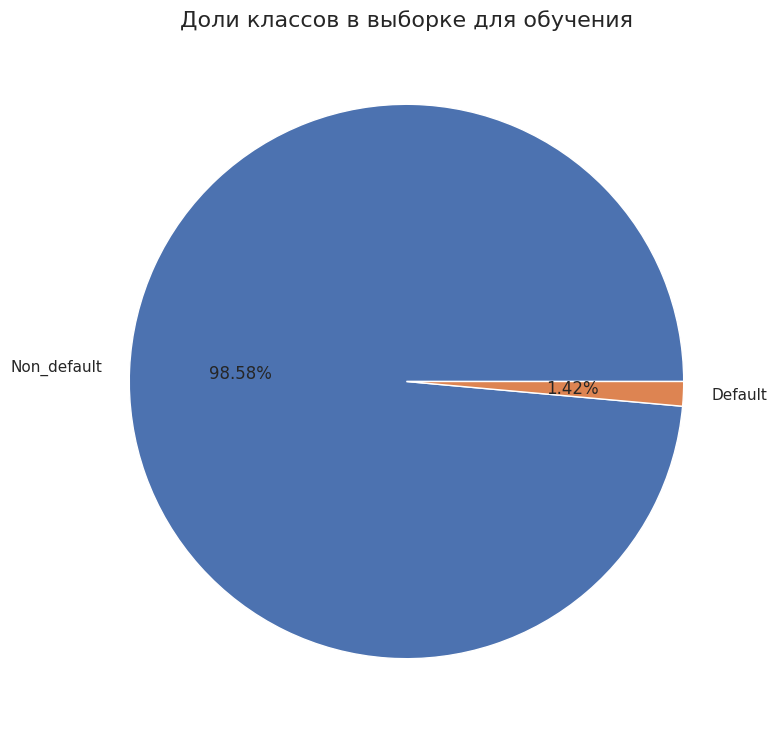

In [ ]:
plt.title("Доли классов в выборке для обучения", fontsize=16)
plt.pie(y_train.target.value_counts(), labels=['Non_default', 'Default'],autopct="%0.2f%%")

plt.show()

Видно, что случаев дефолта в выборке сильно меньше, чем недефолта; другими словами, распределение целевой переменной в нашей задаче крайне несбалансирвано. Это как накладывает ряд ограничений на возможные метрики качества (например, использование ```accuracy``` будет нерепрезентативным), так и отражается на эффективности некоторых подходов к решению (например, логично ожидать достаточно невысокого качества метрических подходов, если не будет наблюдаться явной кластеризации случаев дефолта)


Далее отразим информацию с типами признаков в данных и количестве пропусков

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89975 entries, 51535 to 15795
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   max_card_utilization               64772 non-null  float64
 1   overdue_ratio                      86640 non-null  float64
 2   loan_count                         87397 non-null  float64
 3   min_balance_amount                 83050 non-null  float64
 4   avg_balance_amount                 83050 non-null  float64
 5   total_income_3m                    77658 non-null  float64
 6   max_deposit_amount_5y              7382 non-null   float64
 7   transactions_sum_medicine          57642 non-null  float64
 8   transactions_count_cash_services   77305 non-null  float64
 9   income_transactions_sum            73940 non-null  float64
 10  transactions_sum_cash              58820 non-null  float64
 11  transactions_count_fashion_retail  77305 non-null  floa

Все признаки являются числовыми, что дает надежду на отсутствие необходимости возиться с категориальными фичами. Однако не трудно заметить, что в данных имеется немалое колиество пропусков, а значит есть необходимости перед построением моделей озаботиться их заполнением

Чтобы окончательно увериться с типами признаков, взглянем на число уникальных значений каждого из них

In [ ]:
X_train.nunique()

,0
max_card_utilization,35849
overdue_ratio,11901
loan_count,106
min_balance_amount,26817
avg_balance_amount,81205
total_income_3m,71258
max_deposit_amount_5y,2687
transactions_sum_medicine,47466
transactions_count_cash_services,462
income_transactions_sum,58123


Видно, что везде есть хотя бы 100 уникальных значений, так что можно в целом воспринимать все признаки как числовые

### Работа с признаками

#### Блок со общими вспомогательными функциями

In [ ]:
def calc_buckets(x, n_buckets=20):
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets


def woe_transform(badrate, offset):
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""

    woe = logit(badrate) - offset
    return woe


def get_interval_boundaries(p, n, flag = 0, alpha=0.05):
  """Вычисление левой/правой границы интервала Вальда для badrate"""
  z = sps.norm.ppf(1-alpha/2) # Нужная квантиль
  sts = z * np.sqrt(p * (1 - p) / n) # Статистика для границ интервала
  return max(0, p - sts) if flag == 0 else min(1, p + sts) # Если flag 0, то вернется левая граница, иначе - правая


def woe_ci(target, buckets, offset):
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    # группируем target по bucket и вычисляем badrate (просто среднее по таргету) и количество наблюдений в bucket
    grouped = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['mean', 'count'])['target']
    # векторизованная функция вычисления границ интервала
    vFunc = np.vectorize(get_interval_boundaries)

    # считаем бэдрейт и доверительный интервал для него (любым способом)
    badrate = grouped['mean'].values
    badrate_lower = vFunc(grouped['mean'], grouped['count'], 0)
    badrate_upper = vFunc(grouped['mean'], grouped['count'], 1)

    # переходим от бэдрейта к woe
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper

def evaluate_iv(values, target, buckets):
    '''Отдельная функция для нахождения IV'''
    # Нахождение WoE
    offset = logit(np.mean(target))
    woe, _, _ = woe_ci(target, buckets, offset)

    # Нахождение статистики распределений целевой переменной по buckets и вообще
    buckets_stats = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['sum', 'count'])['target']

    # Статистика для IV
    bad_buckets = buckets_stats['sum']
    good_buckets = buckets_stats['count'] - buckets_stats['sum']
    bad_overall = np.sum(target)
    good_overall = target.shape[0] - bad_overall

    # Непосрдественное вычисление IV
    IV = np.sum((bad_buckets / bad_overall - good_buckets / good_overall) * woe)

    return IV

In [ ]:
def get_iv(feature):
    """
    Функция для перебора различных простых вариантов заполнения пропусков
    в числовых признаках, с расчетом показателя IV для каждого варианта
    """
    potential_fillers = {
        "Среднее": X_train[feature].mean(),
        "Медиана": X_train[feature].median(),
        "Ноль": 0,
        "Константа вне нижней границы значений": X_train[feature].min() - 0.0000001,
        "Константа вне верхней границы значений": X_train[feature].max() + 0.0000001
    }

    base_iv = evaluate_iv(
        X_train.loc[X_train[feature].notna(), feature],
        y_train.loc[X_train[feature].notna(), 'target'],
        calc_buckets(X_train.loc[X_train[feature].notna(), feature])
    )

    results = []

    X_trial = X_train.copy(deep=True)

    for filler in potential_fillers.values():
        X_trial.loc[X_train[feature].isna(), feature] = filler

        iv = evaluate_iv(
            X_trial.loc[:, feature],
            y_train.loc[:, 'target'],
            calc_buckets(X_trial.loc[:, feature])
        )

        results.append(round(iv, 5))

    print("Исходный IV (без пропусков) - ", round(base_iv, 5))
    return pd.DataFrame({'Заполнитель': potential_fillers.keys(), 'IV': results})

#### Непосредственно анализ признаков

Сперва, так как мы воспринимаем все признаки как числовые, необходимо убедиться в отсутствии мультиколлинеарности. Для этого выведем матрицу попарной корреляции

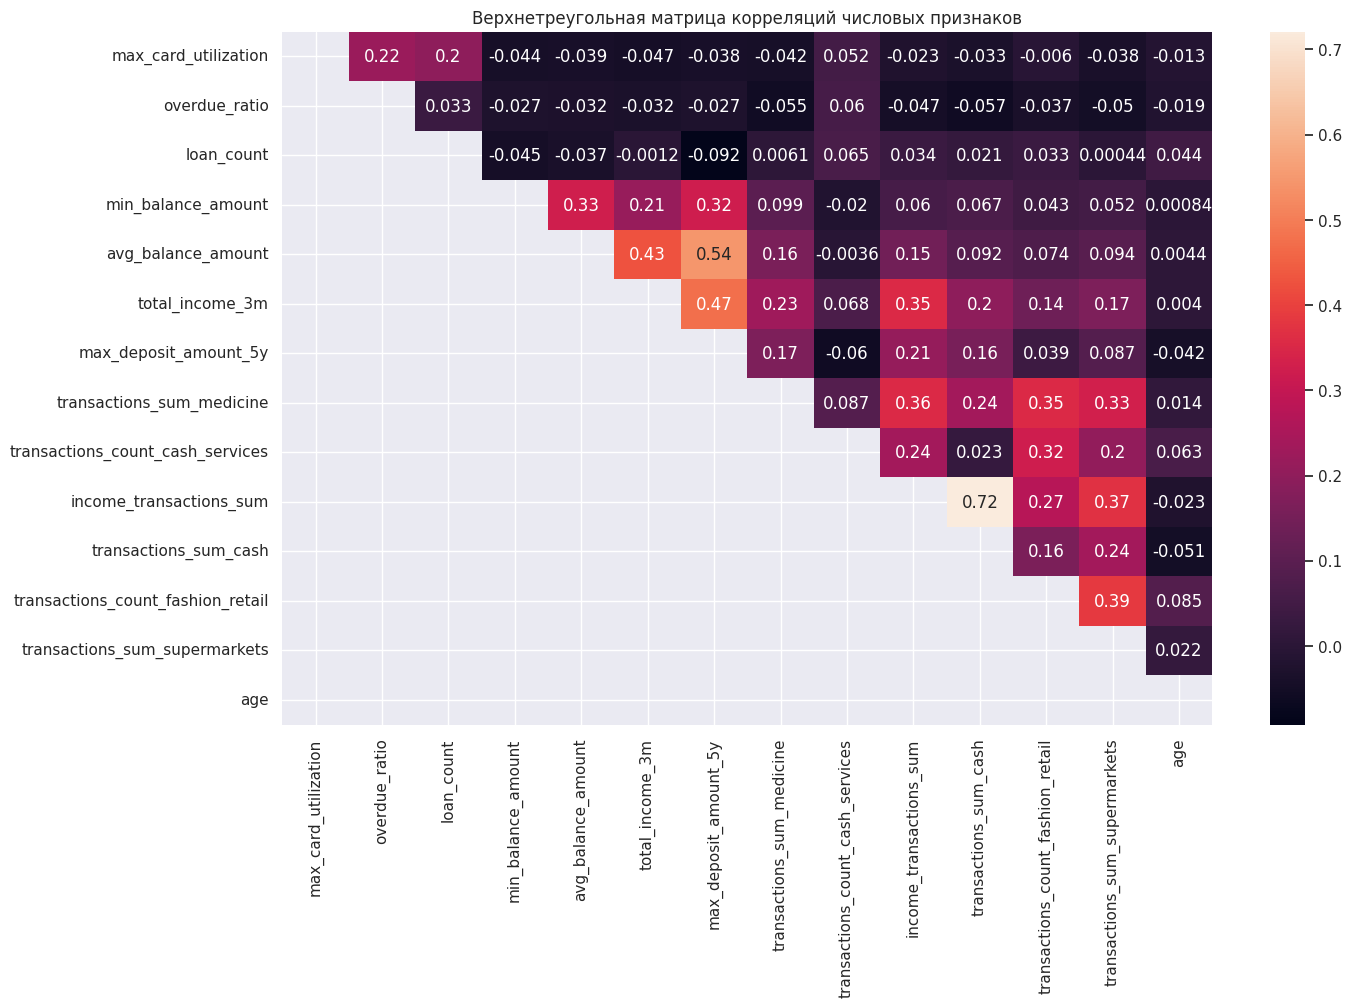

In [ ]:
correlations = X_train.corr()

sns.heatmap(correlations, annot=True, mask=np.tril(np.ones_like(correlations, dtype=bool)))
plt.title("Верхнетреугольная матрица корреляций числовых признаков")

plt.show()

По графику видно, что большая часть признаков слабо связана друг с другом, хотя имеется несколько высоких по абсолютной величине связей. Однако в целом можно утверждать, что существенной мультиколлинеарности в данных нет.

Далее производится последовательный анализ каждого признака. Сама методология анализа следующая:

1. Рассчитывается доля пропусков в данных, и если показатель превышает 30% то анализ признака представляется затруднительным;
2. Выводится набор базовых статистик и строится гистограмма распределений признака в каждом классе (дефолт/не дефолт) - позволяет оценить необходимость обработки выбросов в данных;
3. При наличии выбросов анализируется сжатие верхнего квантиля: если это сжатие позволяет получить величину IV (Information Value - простейшая метрика для оценки разделяющей способности признака), то оно производится (иначе все оставляется в том же виде);
4. Далее рассматривается пять вариантов заполения пропусков: среднее, медиана, 0, число за минимальной границей значений, число за максимальной границей значений. Для каждого из этих вариантов рассчитывается IV и сравнивается с исходным IV (уже после сжатия, но без всех пропусков). Выбирается вариант с наименьшей потерей по IV.

Подробнее про [IV](https://wiki.loginom.ru/articles/information-value.html)

In [ ]:
# Словари, хранящие значения для заполнения пропусков, границы сжатия (для убирания выбросов) и стратегии заполнения пропусков (нужно для валидации)
na_fillers = {feature: -1 for feature in X_train.columns}
boundaries = {feature: (-np.inf, np.inf) for feature in X_train.columns}
filling_strategy = {feature: 'const' for feature in X_train.columns}

##### max_card_utilization

Первый признак - максимальная утилизация по действующей кредитной карте

In [ ]:
print(f"Доля пропусков - {X_train['max_card_utilization'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.28


In [ ]:
X_train['max_card_utilization'].describe()

,max_card_utilization
count,64772.000000
mean,0.399798
std,0.406808
min,0.000000
25%,0.000000
50%,0.260995
75%,0.862930
max,1.000000


Видно, что признак полностью заключен в границах от 0 до 1 (что и ожидается от показателя утилизации). Значит обрабатывать выбросы здесь нет необходимости

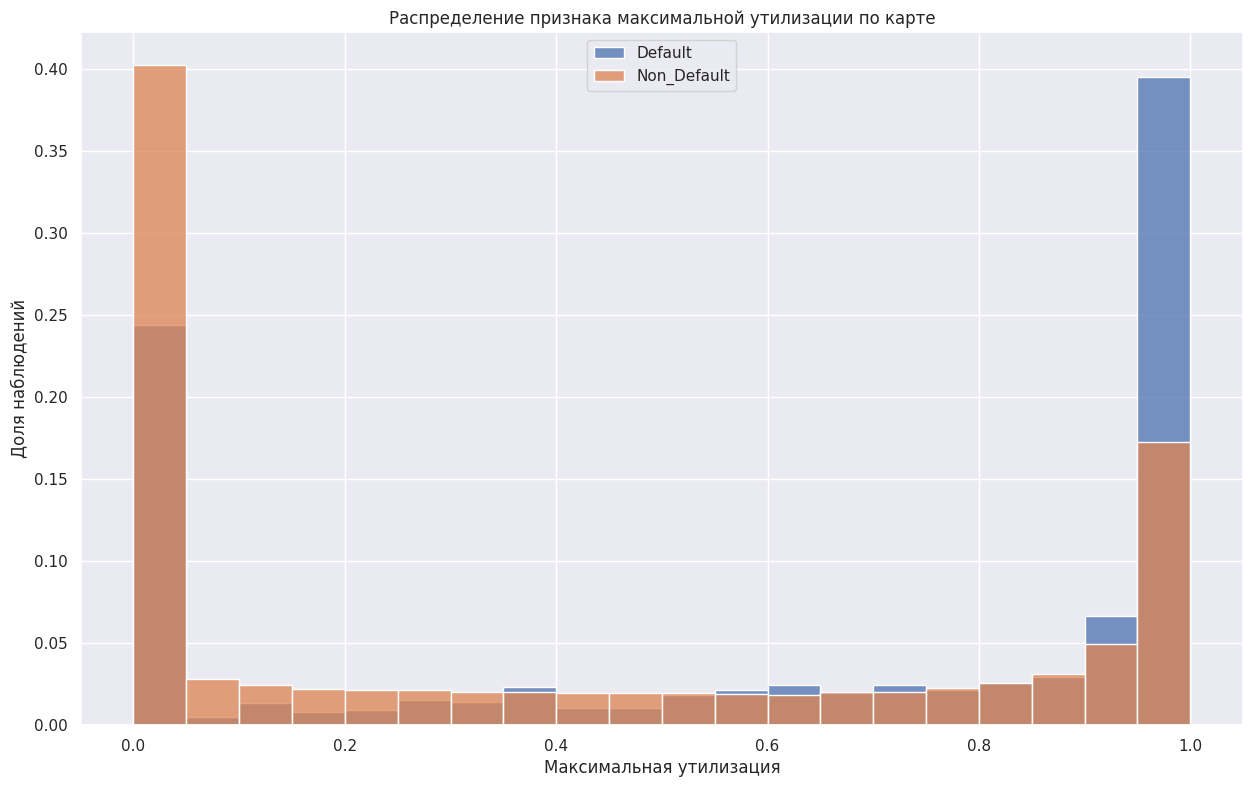

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='max_card_utilization', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='max_card_utilization', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение признака максимальной утилизации по карте')
plt.xlabel('Максимальная утилизация')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

График распределения для обоих классов выглядит схоже: большие пики на хвостах и более-менее равномерное распределение между. При этом, большая доля дефолта сосредоточена в правом хвосте, а у недефолтников - в левом.

In [ ]:
get_iv('max_card_utilization')

Исходный IV (без пропусков) -  0.35347


,Заполнитель,IV
0,Среднее,0.27282
1,Медиана,0.26984
2,Ноль,0.26470
3,Константа вне нижней границы значений,0.26471
4,Константа вне верхней границы значений,0.15664


Наименьшую потерю в IV обеспечивает заполнение средним, значит будем использовать его

In [ ]:
na_fillers['max_card_utilization'] = X_train.max_card_utilization.mean()
filling_strategy['max_card_utilization'] = 'mean'

##### overdue_ratio

Второй признак - отношение числа месяцев, в которых была допущена просрочка, к общему числу месяцев в платежной дисциплине, по всем кредитам (коэффициент просроченной задолженности)

In [ ]:
print(f"Доля пропусков - {X_train['overdue_ratio'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.04


In [ ]:
X_train['overdue_ratio'].describe()

,overdue_ratio
count,86640.000000
mean,0.056190
std,0.102068
min,0.000000
25%,0.000000
50%,0.014851
75%,0.063572
max,2.393939


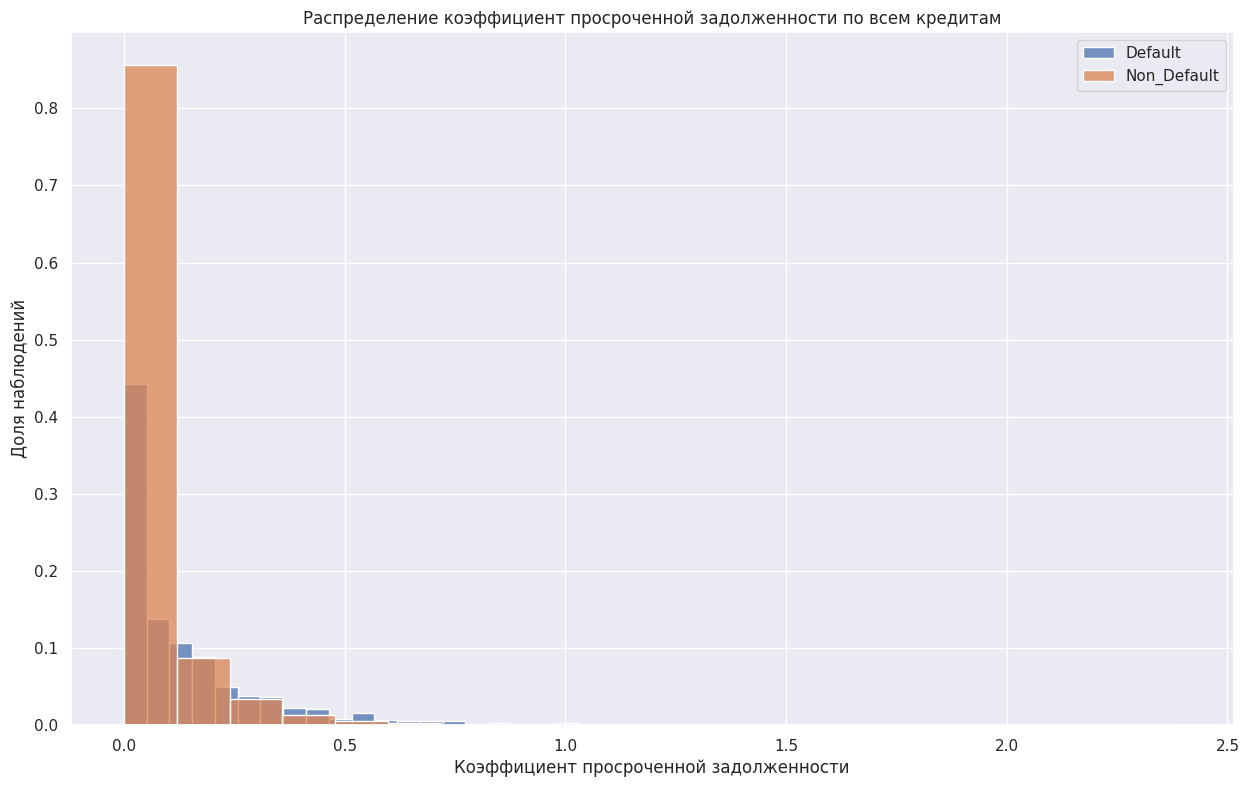

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='overdue_ratio', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='overdue_ratio', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение коэффициент просроченной задолженности по всем кредитам')
plt.xlabel('Коэффициент просроченной задолженности')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Видно, что распределение данного признака неравномерно - явно имеются выбросы в правом хвосте распределения; однако квантильное сжатие в данном случае приводило к потерям IV, поэтому лучше его не производить

In [ ]:
get_iv('overdue_ratio')

Исходный IV (без пропусков) -  0.44761


,Заполнитель,IV
0,Среднее,0.43108
1,Медиана,0.42602
2,Ноль,0.39567
3,Константа вне нижней границы значений,0.39566
4,Константа вне верхней границы значений,0.39459


Наименьшую просадку по IV вновь обеспечивает заполнение средним

In [ ]:
na_fillers['overdue_ratio'] = X_train.overdue_ratio.mean()
filling_strategy['overdue_ratio'] = 'mean'

##### min_balance_amount

Третий признак - минимальный остаток по всем счетам клиента за последний год

In [ ]:
print(f"Доля пропусков - {X_train['min_balance_amount'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.08


In [ ]:
X_train['min_balance_amount'].describe()

,min_balance_amount
count,8.305000e+04
mean,2.674834e+04
std,3.535838e+05
min,1.000000e-02
25%,3.000000e+00
50%,2.236500e+01
75%,1.084600e+02
max,2.800000e+07


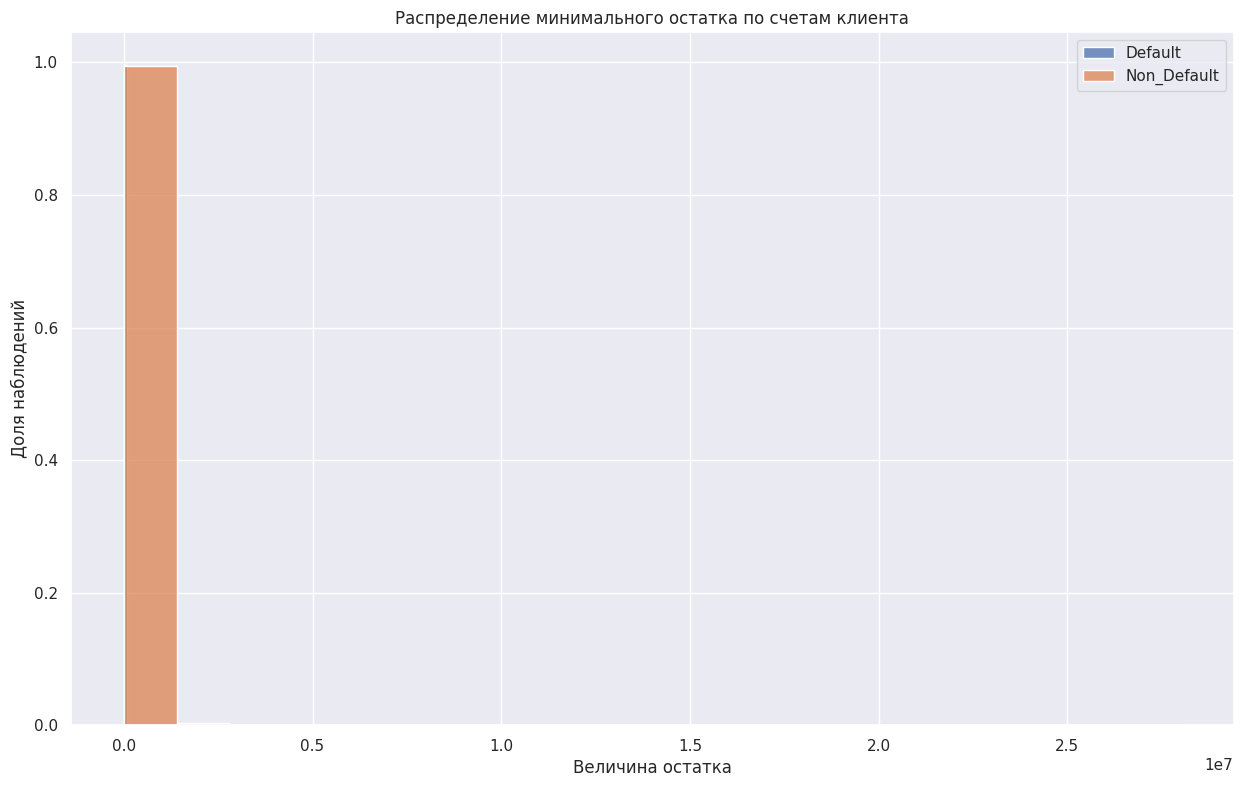

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='min_balance_amount', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='min_balance_amount', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение минимального остатка по счетам клиента')
plt.xlabel('Величина остатка')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Распределение признака выглядит достаточно удручающе: один столбец в левой части, аккумулирующий одинаковые доли у обоих классов и наличие мощных выбросов. Здесь сжатие 1% самых больших значений позволяет несколько нарастить IV у признака

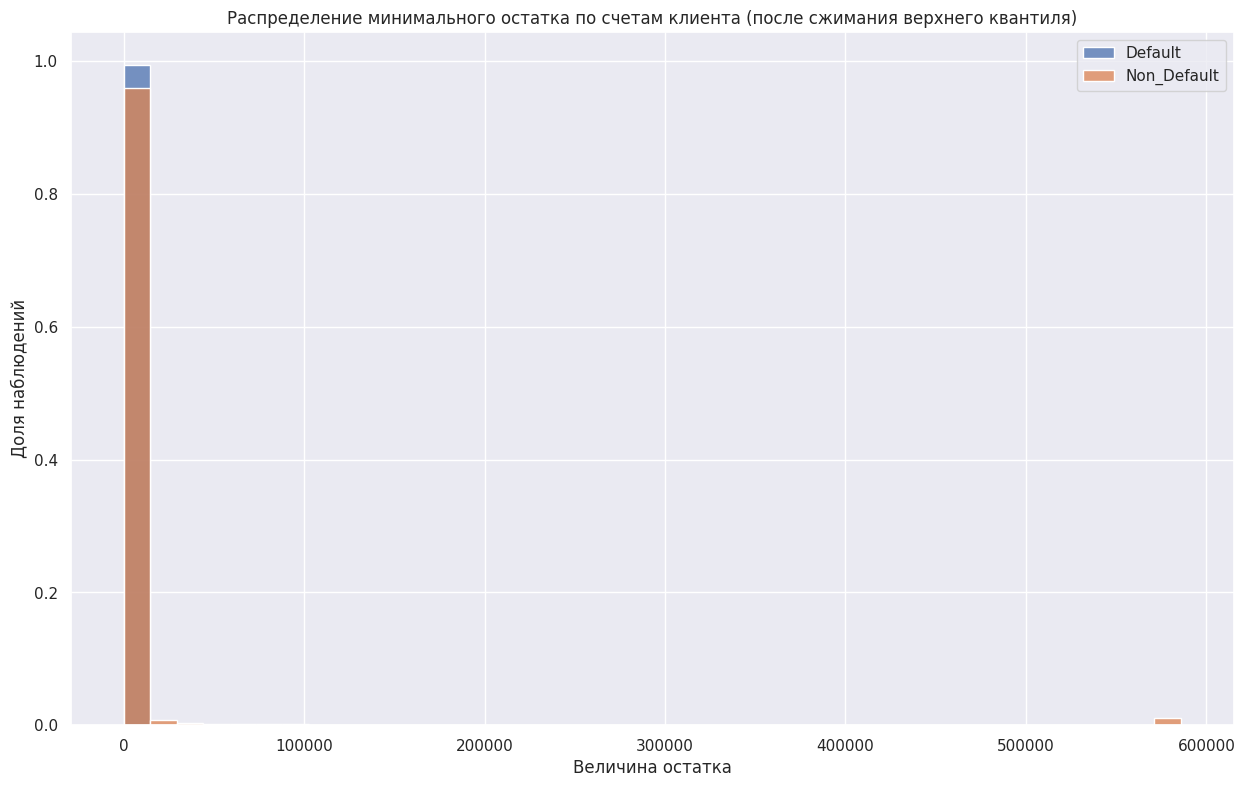

In [ ]:
X_train_mod = X_train['min_balance_amount'].clip(0, X_train['min_balance_amount'].quantile(0.99)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='min_balance_amount', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='min_balance_amount', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение минимального остатка по счетам клиента (после сжимания верхнего квантиля)')
plt.xlabel('Величина остатка')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

На таком графике даже прослеживается, что шанс уйти в дефолт у клиента с малой величиной остатка выше, чем с большой (что логично)

In [ ]:
boundaries['min_balance_amount'] = (0, X_train['min_balance_amount'].quantile(0.99))
X_train['min_balance_amount'] = X_train_mod['min_balance_amount']

get_iv('min_balance_amount')

Исходный IV (без пропусков) -  0.21317


,Заполнитель,IV
0,Среднее,0.17864
1,Медиана,0.19641
2,Ноль,0.19507
3,Константа вне нижней границы значений,0.19507
4,Константа вне верхней границы значений,0.15345


Наименьшую потерю обеспечивает кодирование медианой, следовательно будем использовать ее

In [ ]:
na_fillers['min_balance_amount'] = X_train['min_balance_amount'].median()
filling_strategy['min_balance_amount'] = 'median'

##### avg_balance_amount

Четвертый признак - средний остаток по всем счетам клиента за последние 12 мес

In [ ]:
print(f"Доля пропусков - {X_train['avg_balance_amount'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.08


In [ ]:
X_train['avg_balance_amount'].describe()

,avg_balance_amount
count,8.305000e+04
mean,3.408442e+05
std,3.640953e+06
min,3.300000e-04
25%,7.734354e+03
50%,2.599697e+04
75%,8.256808e+04
max,3.700647e+08


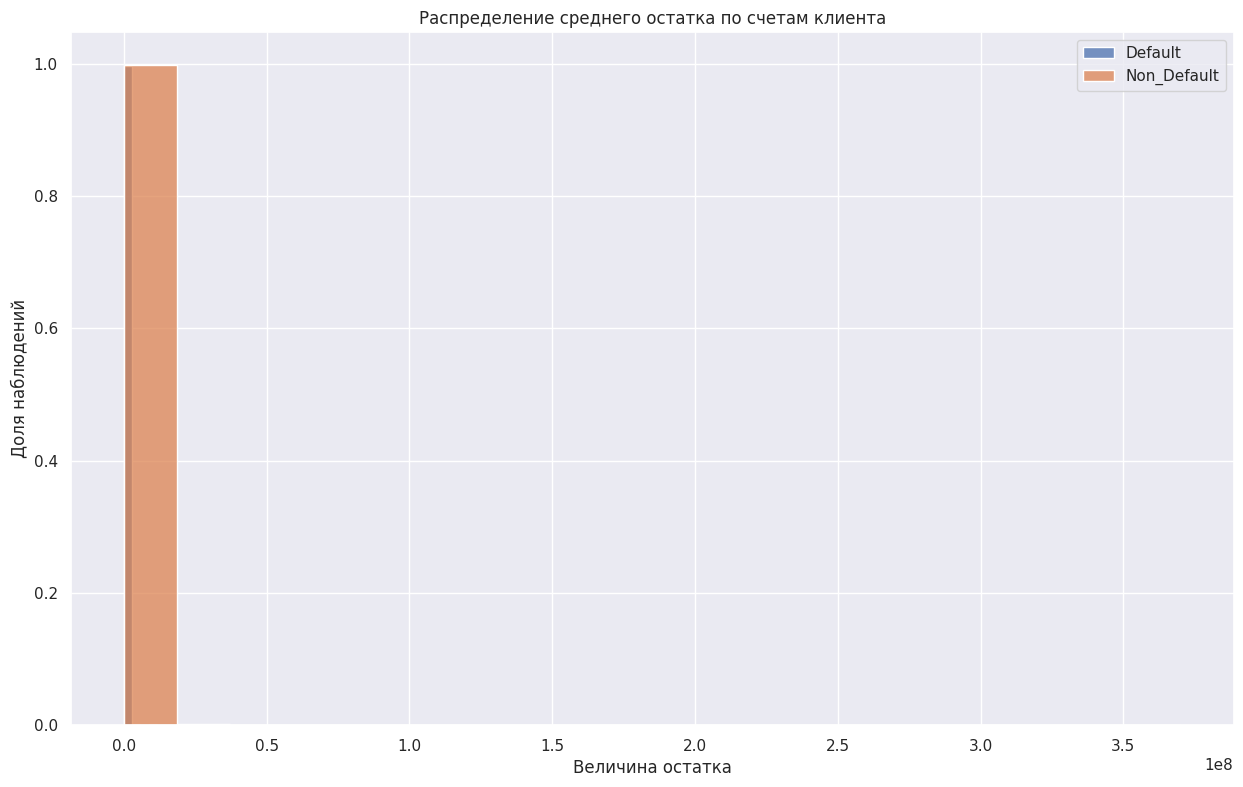

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='avg_balance_amount', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='avg_balance_amount', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение среднего остатка по счетам клиента')
plt.xlabel('Величина остатка')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Снова распределение выглядит необнадеживающе, однако здесь сжатие квантиля не способствует росту IV (следовательно, не применялось)

In [ ]:
get_iv('avg_balance_amount')

Исходный IV (без пропусков) -  0.19374


,Заполнитель,IV
0,Среднее,0.16093
1,Медиана,0.17724
2,Ноль,0.17890
3,Константа вне нижней границы значений,0.17890
4,Константа вне верхней границы значений,0.12084


Наименьшая потеря достигается путем кодирования пропусков нулем, значит так и поступим

In [ ]:
na_fillers['avg_balance_amount'] = 0
filling_strategy['avg_balance_amount'] = 'const'


##### total_income_3m

Пятый признак - суммарные поступления в рублях за последние 3 месяца

In [ ]:
print(f"Доля пропусков - {X_train['total_income_3m'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.14


In [ ]:
X_train['total_income_3m'].describe()

,total_income_3m
count,7.765800e+04
mean,1.333139e+06
std,5.675978e+06
min,0.000000e+00
25%,1.648007e+05
50%,4.208301e+05
75%,9.567037e+05
max,3.311446e+08


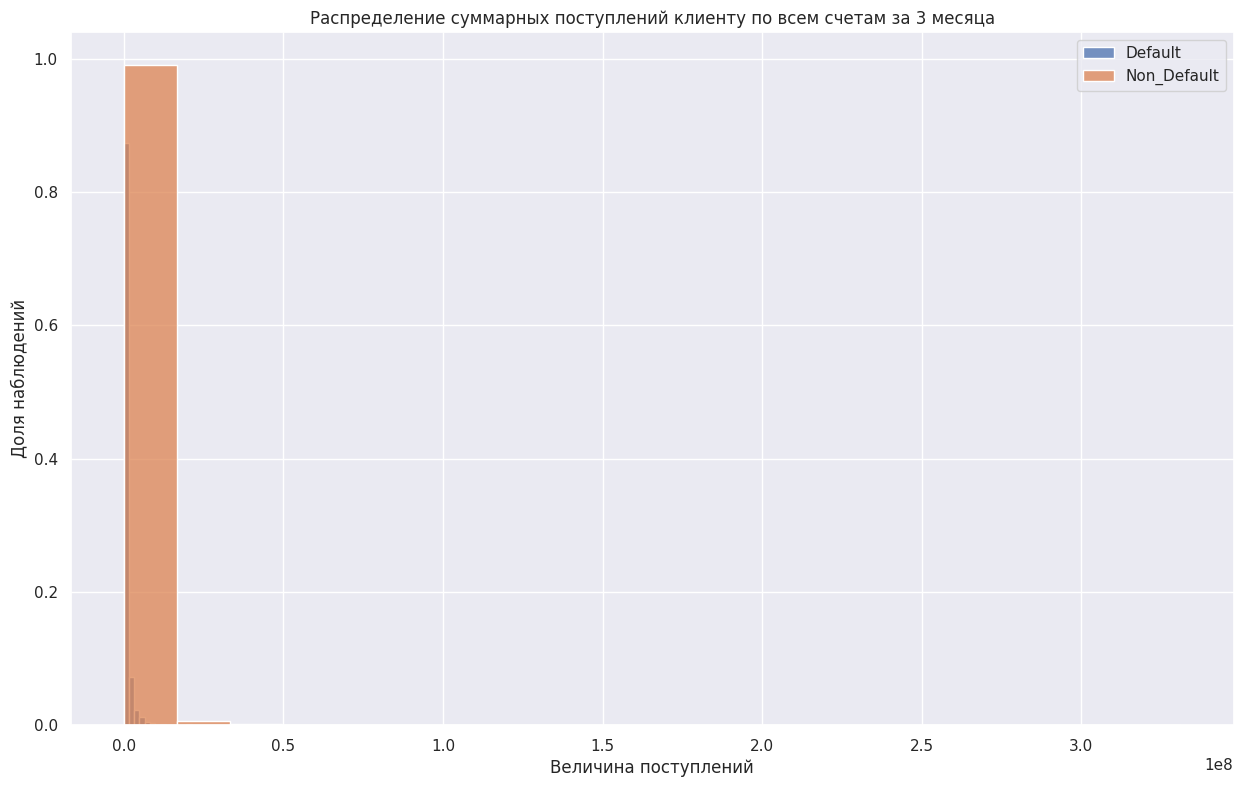

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='total_income_3m', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='total_income_3m', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение суммарных поступлений клиенту по всем счетам за 3 месяца')
plt.xlabel('Величина поступлений')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Снова знакомый "столбец распределения", но для данного признака сжимание верхних 3% позволяет существенно преобразовать распределение (в лучшую сторону, с увеличением IV)

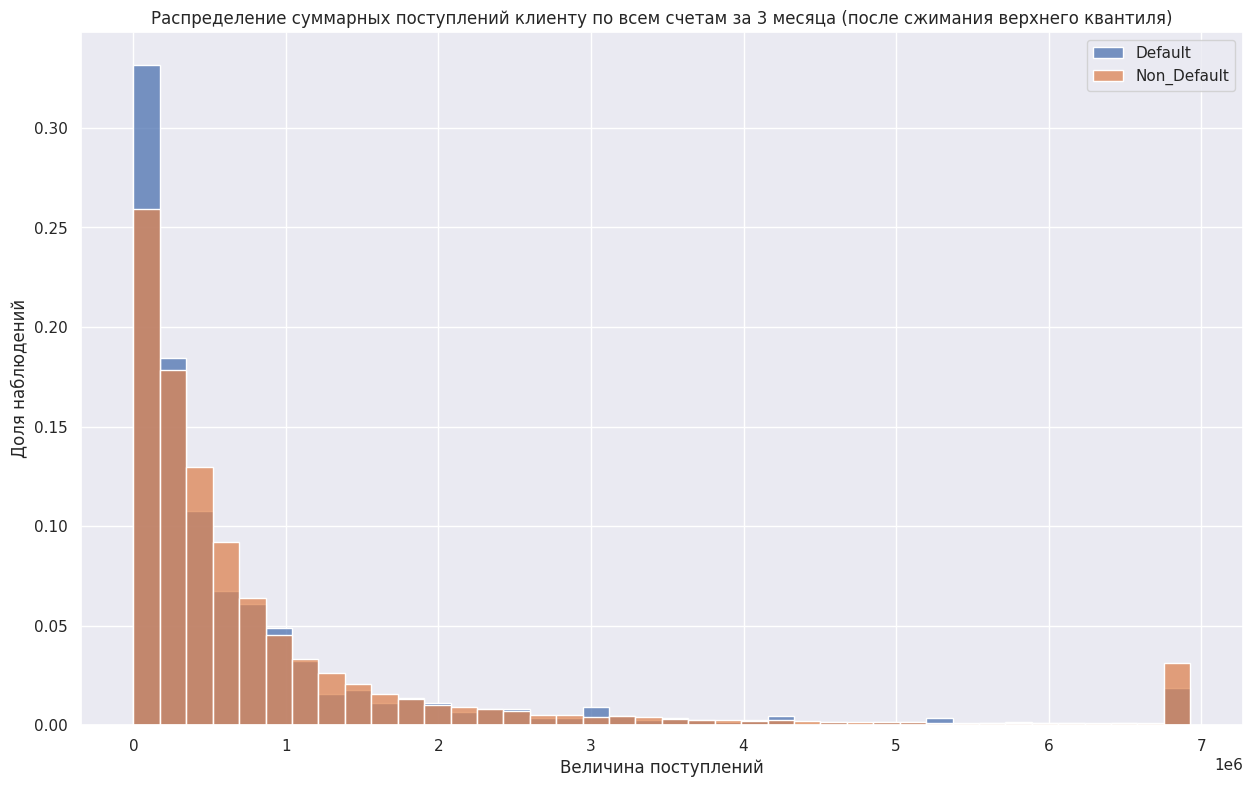

In [ ]:
X_train_mod = X_train['total_income_3m'].clip(0, X_train['total_income_3m'].quantile(0.97)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='total_income_3m', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='total_income_3m', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение суммарных поступлений клиенту по всем счетам за 3 месяца (после сжимания верхнего квантиля)')
plt.xlabel('Величина поступлений')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Полученное распределение выглядит значительно лучше с точки зрения предсказательной способности; в частности, явно виден сильный перекос в дефолт для клиентов с малыми поступлениями (опять же, звучит логично)

In [ ]:
boundaries['total_income_3m'] = (0, X_train['total_income_3m'].quantile(0.97))
X_train['total_income_3m'] = X_train_mod['total_income_3m']

get_iv('total_income_3m')

Исходный IV (без пропусков) -  0.05282


,Заполнитель,IV
0,Среднее,0.04829
1,Медиана,0.04785
2,Ноль,0.04814
3,Константа вне нижней границы значений,0.04815
4,Константа вне верхней границы значений,0.04448


Лучше всего в данном признаке проявляется кодирование средним

In [ ]:
na_fillers['total_income_3m'] = X_train['total_income_3m'].mean()
filling_strategy['total_income_3m'] = 'mean'

##### max_deposit_amount_5y

Шестой признак - максимальная сумма срочных депозитов, открытых за последние 5 лет

In [ ]:
print(f"Доля пропусков - {X_train['max_deposit_amount_5y'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.92


Очень много пропусков в признаке; по выбранному подходу данный признак лучше исключить из рассмотрения

In [ ]:
na_fillers.pop('max_deposit_amount_5y', None)

##### transactions_sum_medicine

Седьмой признак - сумма транзакций в категории "medicine" за последние 12 мес

In [ ]:
print(f"Доля пропусков - {X_train['transactions_sum_medicine'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.36


То же самое: согласно избранной методологии признак не используется

In [ ]:
na_fillers.pop('transactions_sum_medicine', None)

##### income_transactions_sum

Восьмой признак - сумма всех приходных операций за последние 12 месяцев

In [ ]:
print(f"Доля пропусков - {X_train['income_transactions_sum'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.18


In [ ]:
X_train['income_transactions_sum'].describe()

,income_transactions_sum
count,7.394000e+04
mean,4.948482e+05
std,1.075636e+06
min,1.000000e-02
25%,6.729500e+04
50%,2.194529e+05
75%,5.500239e+05
max,7.133800e+07


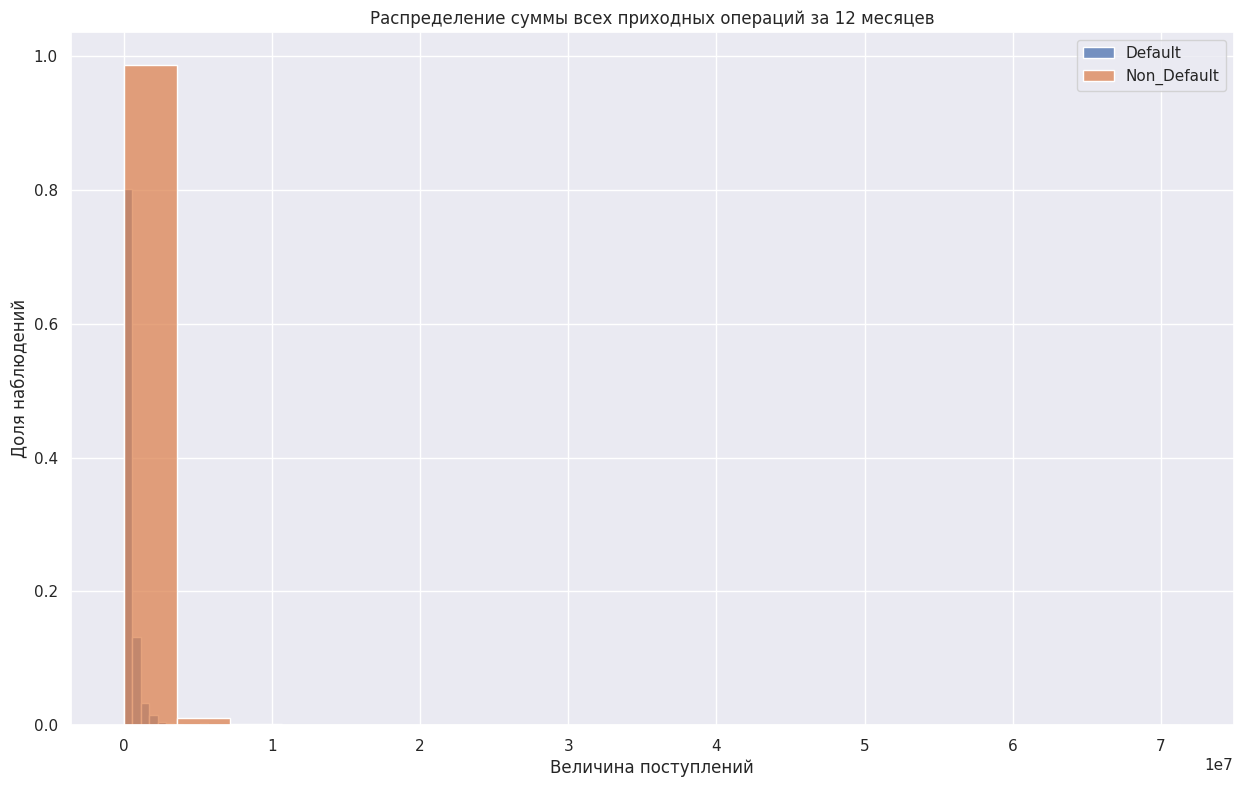

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='income_transactions_sum', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='income_transactions_sum', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение суммы всех приходных операций за 12 месяцев')
plt.xlabel('Величина поступлений')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Вновь знакомое распределение-столб (правда с небольшой ступенькой); здесь правда снова несколько выручает сжимание верхних 3%

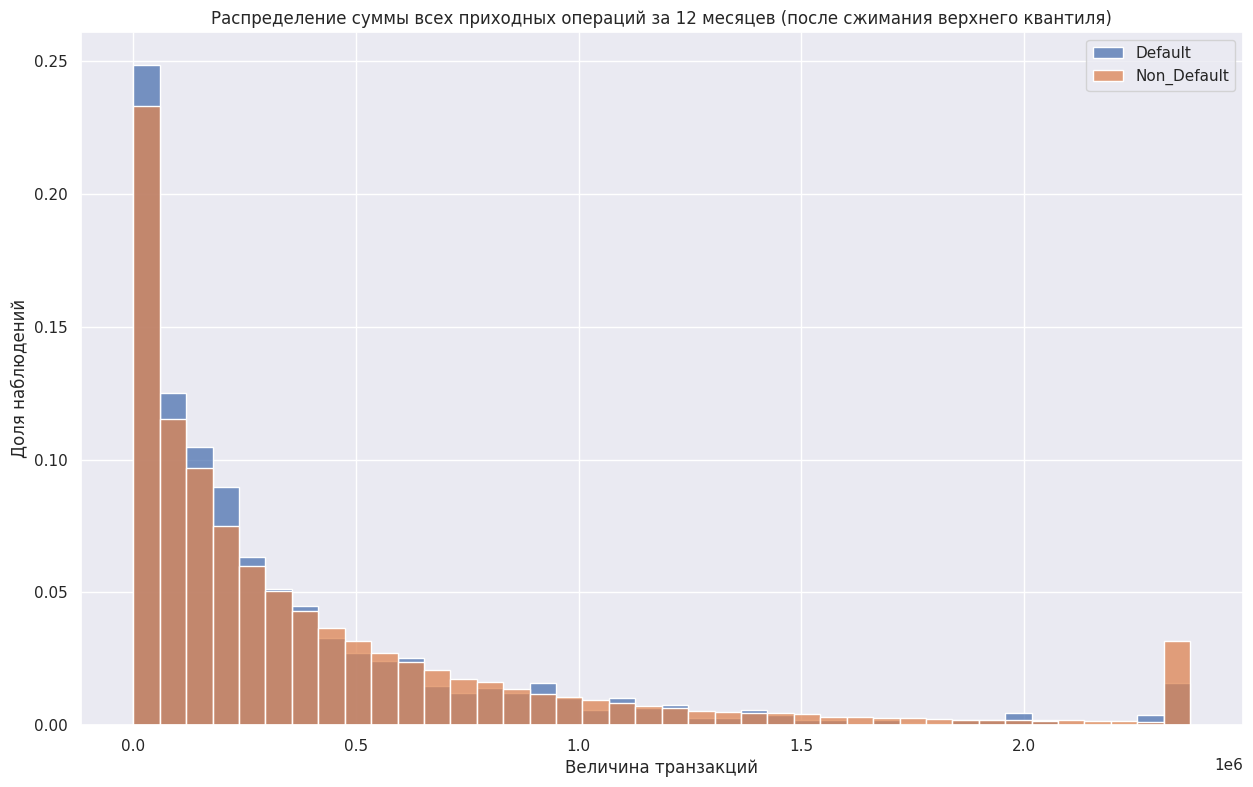

In [ ]:
X_train_mod = X_train['income_transactions_sum'].clip(0, X_train['income_transactions_sum'].quantile(0.97)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='income_transactions_sum', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='income_transactions_sum', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение суммы всех приходных операций за 12 месяцев (после сжимания верхнего квантиля)')
plt.xlabel('Величина транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Вид распределения явно улучшился; так, четко прослеживается, что шансы дефолта (т.е. отношение вероятности дефолта к недефолту) более-менее плавно уменьшаются с ростом размера суммы

In [ ]:
boundaries['income_transactions_sum'] = (0, X_train['income_transactions_sum'].quantile(0.97))
X_train['income_transactions_sum'] = X_train_mod['income_transactions_sum']

get_iv('income_transactions_sum')

Исходный IV (без пропусков) -  0.02918


,Заполнитель,IV
0,Среднее,0.02538
1,Медиана,0.02305
2,Ноль,0.02125
3,Константа вне нижней границы значений,0.02125
4,Константа вне верхней границы значений,0.02017


Наименьшие потери достигаются через среднее, берем его

In [ ]:
na_fillers['income_transactions_sum'] = X_train['income_transactions_sum'].mean()
filling_strategy['income_transactions_sum'] = 'mean'

##### transactions_sum_cash

Девятый признак - сумма транзакций, связанных с взносом наличных, за последние 12 месяцев

In [ ]:
print(f"Доля пропусков - {X_train['transactions_sum_cash'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.35


Процентов пропусков в данных больше пороговой величины, поэтому признак не берем

In [ ]:
na_fillers.pop('transactions_sum_cash', None)

##### transactions_sum_supermarkets

Десятый признак - сумма транзакций в категории "supermarkets" за последние 12 мес

In [ ]:
print(f"Доля пропусков - {X_train['transactions_sum_supermarkets'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.27


In [ ]:
X_train['transactions_sum_supermarkets'].describe()

,transactions_sum_supermarkets
count,6.607200e+04
mean,5.681612e+04
std,9.875766e+04
min,1.000000e+00
25%,9.852167e+03
50%,3.201868e+04
75%,7.430426e+04
max,1.060883e+07


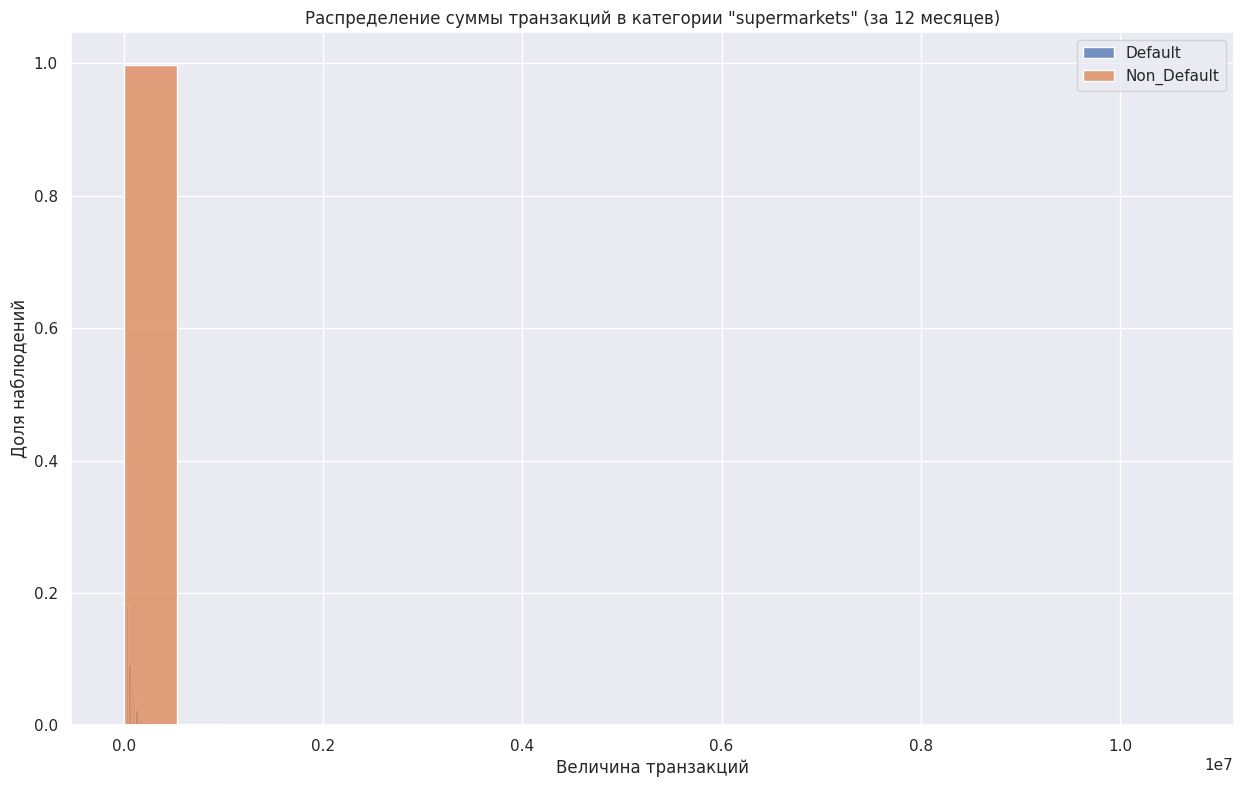

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='transactions_sum_supermarkets', stat='probability', bins=20, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='transactions_sum_supermarkets', stat='probability', bins=20, label='Non_Default')
plt.title('Распределение суммы транзакций в категории "supermarkets" (за 12 месяцев)')
plt.xlabel('Величина транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Вновь знакомый столбец, вновь удается исправить за счет сжатия верхних 2%

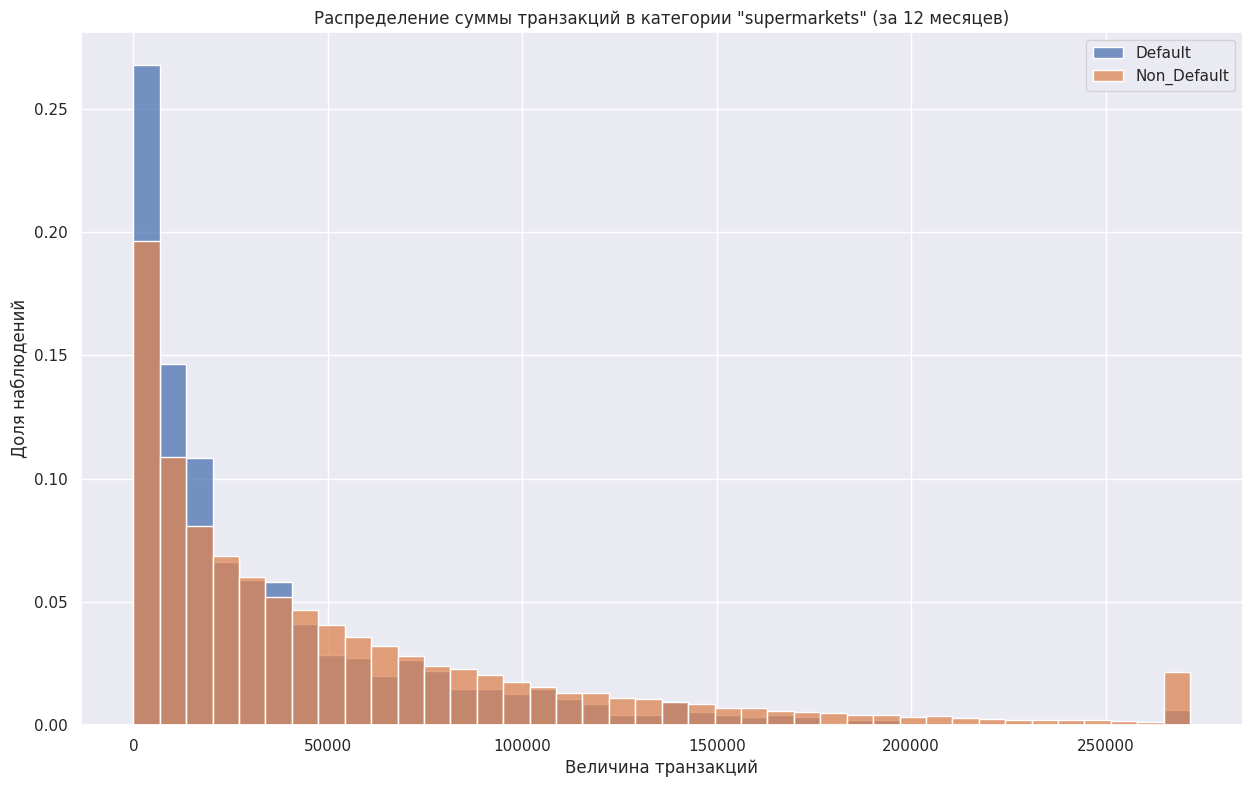

In [ ]:
X_train_mod = X_train['transactions_sum_supermarkets'].clip(0, X_train['transactions_sum_supermarkets'].quantile(0.98)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='transactions_sum_supermarkets', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='transactions_sum_supermarkets', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение суммы транзакций в категории "supermarkets" (за 12 месяцев)')
plt.xlabel('Величина транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()


Распределение выглядит значительно лучше, явно вырисовывается плавное снижение шанса выхода в дефолт с наращиванием размера потраченной суммы

In [ ]:
boundaries['transactions_sum_supermarkets'] = (0, X_train['transactions_sum_supermarkets'].quantile(0.98))
X_train['transactions_sum_supermarkets'] = X_train_mod['transactions_sum_supermarkets']

get_iv('transactions_sum_supermarkets')

Исходный IV (без пропусков) -  0.14156


,Заполнитель,IV
0,Среднее,0.10107
1,Медиана,0.10378
2,Ноль,0.10039
3,Константа вне нижней границы значений,0.10039
4,Константа вне верхней границы значений,0.06392


Здесь для кодирования лучше использовать медиану, так что берем ее

In [ ]:
na_fillers['transactions_sum_supermarkets'] = X_train['transactions_sum_supermarkets'].median()
filling_strategy['transactions_sum_supermarkets'] = 'median'

##### loan_count

Одиннадцатый признак - количество кредитов у клиента

In [ ]:
print(f"Доля пропусков - {X_train['loan_count'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.03


In [ ]:
X_train['loan_count'].describe()

,loan_count
count,87397.000000
mean,10.101868
std,7.816462
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,333.000000


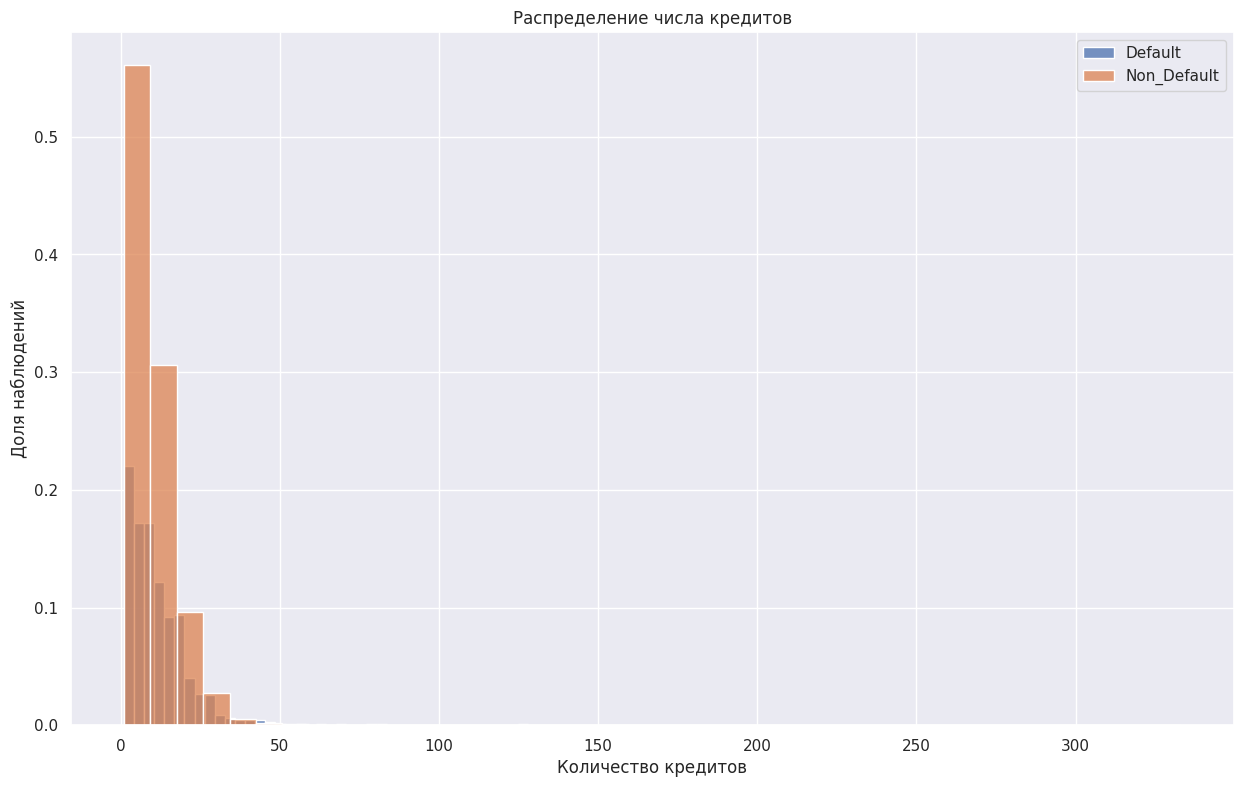

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='loan_count', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='loan_count', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение числа кредитов')
plt.xlabel('Количество кредитов')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Имеет место действительно некоторое распределение (не просто столбец), которое, тем не менее, можно немного улучшить, сжав 1% верхних значений

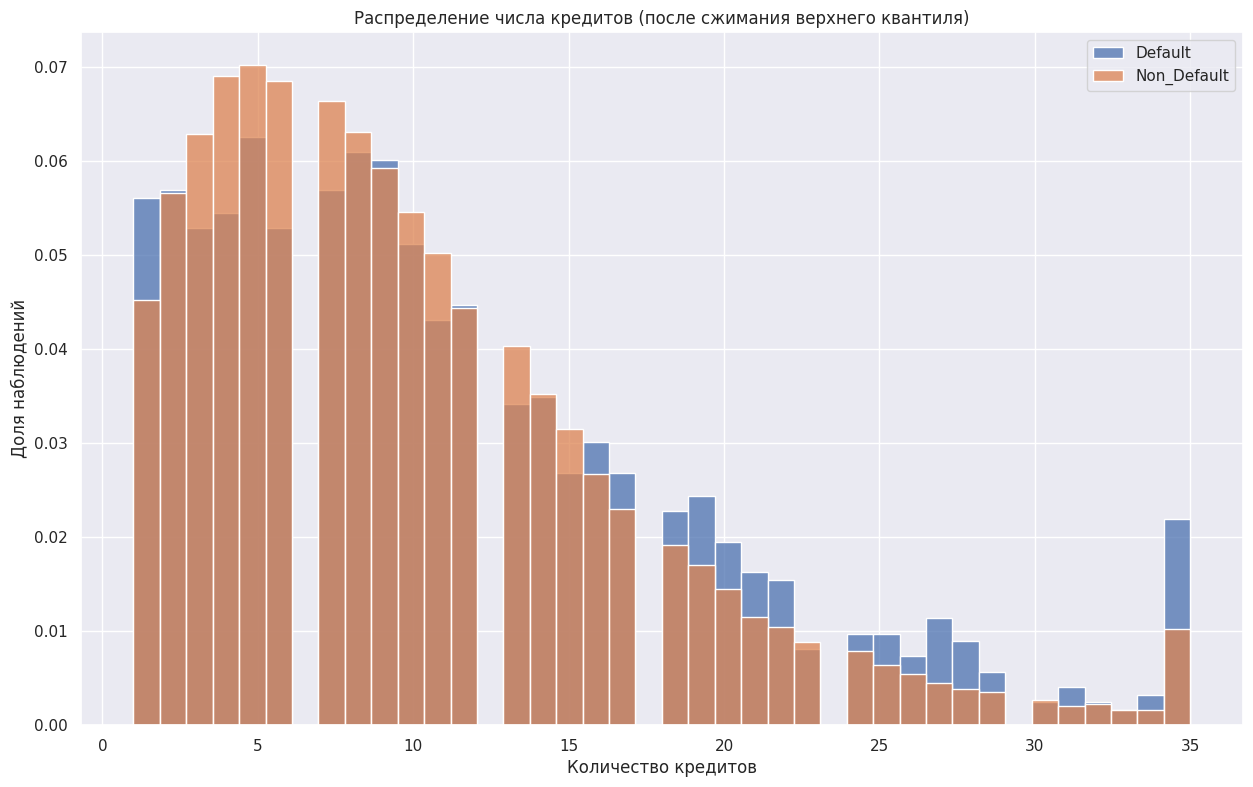

In [ ]:
X_train_mod = X_train['loan_count'].clip(0, X_train['loan_count'].quantile(0.99)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='loan_count', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='loan_count', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение числа кредитов (после сжимания верхнего квантиля)')
plt.xlabel('Количество кредитов')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

На полученном распределении прослеживается своего рода закономерность: при первом кредите шанс дефолта относительно большой, затем при малом количестве он становится меньше, но при последующем увеличении числа займов шанс дефолта вновь становится больше

In [ ]:
boundaries['loan_count'] = (0, X_train['loan_count'].quantile(0.99))
X_train['loan_count'] = X_train_mod['loan_count']

get_iv('loan_count')

Исходный IV (без пропусков) -  0.0473


,Заполнитель,IV
0,Среднее,0.04909
1,Медиана,0.04633
2,Ноль,0.04851
3,Константа вне нижней границы значений,0.04851
4,Константа вне верхней границы значений,0.04377


Здесь за счет кодирования пропусков нам зачастую удается даже несколько повысить IV (что бывает ввобще говоря нечасто); наибольшую прибавку вновь получаем за счет кодирования средним

In [ ]:
na_fillers['loan_count'] = X_train['loan_count'].mean()
filling_strategy['loan_count'] = 'mean'

##### transactions_count_cash_services

Двенадцатый признак - количество транзакций в категории "cash services" за последние 12 месяцев

In [ ]:
print(f"Доля пропусков - {X_train['transactions_count_cash_services'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.14


In [ ]:
X_train['transactions_count_cash_services'].describe()

,transactions_count_cash_services
count,77305.000000
mean,51.791605
std,52.759720
min,0.000000
25%,13.000000
50%,38.000000
75%,74.000000
max,1059.000000


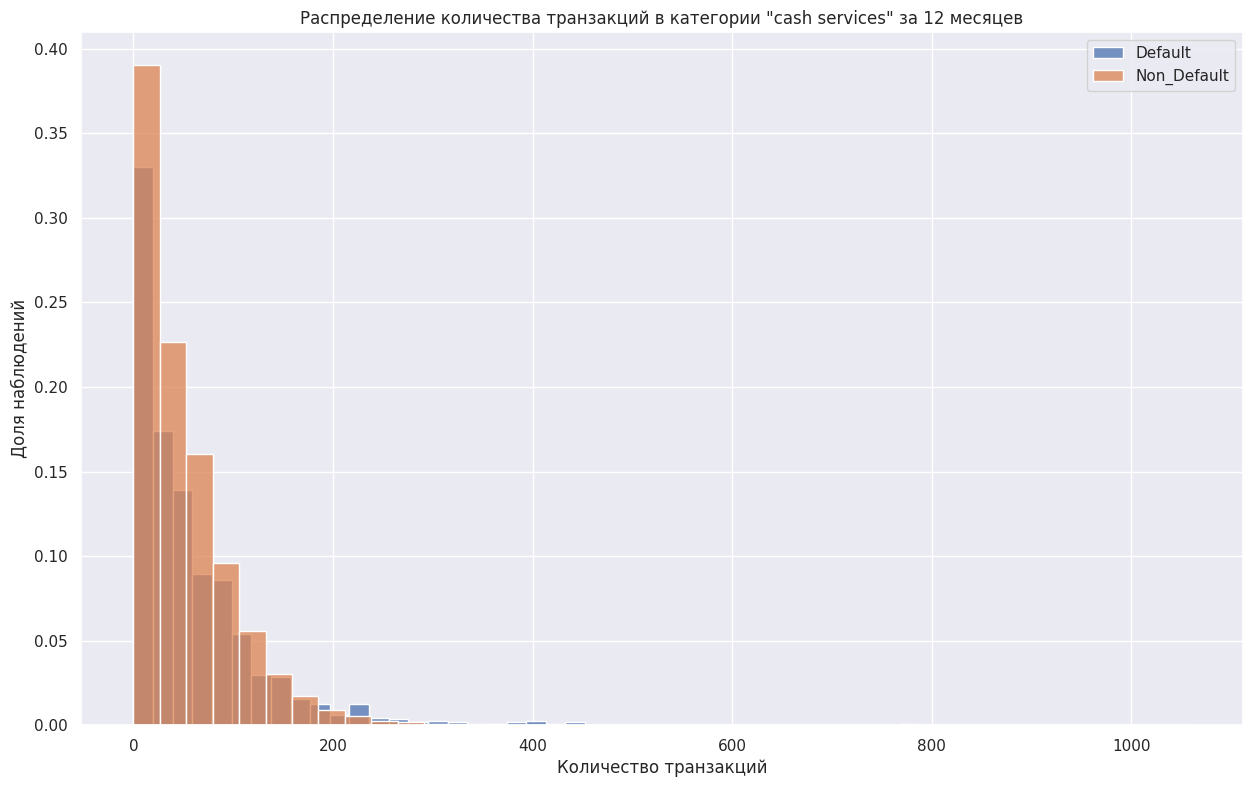

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='transactions_count_cash_services', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='transactions_count_cash_services', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение количества транзакций в категории "cash services" за 12 месяцев')
plt.xlabel('Количество транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

График действительно выглядит как некое распределение, но в нем явно есть сильные выбросы. Сжатие 1% верхних значений можно получить более адекватное распределение

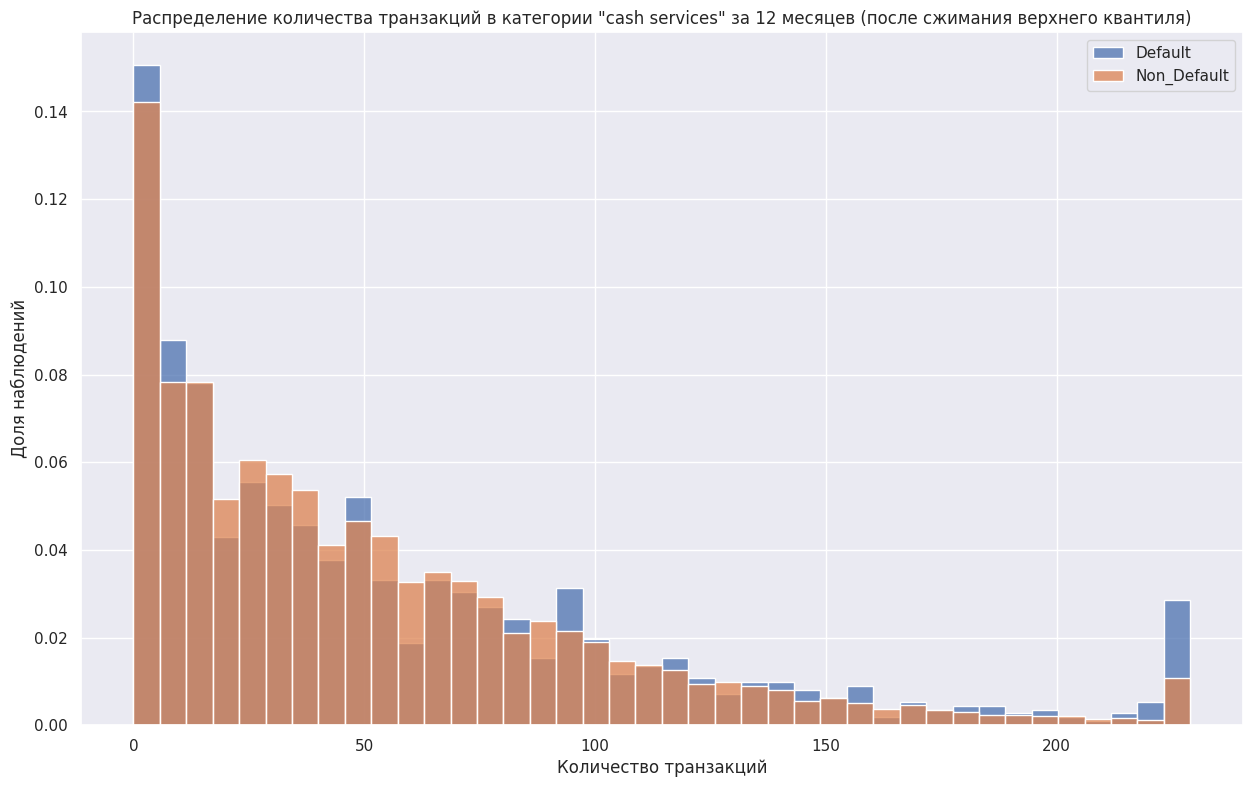

In [ ]:
X_train_mod = X_train['transactions_count_cash_services'].clip(0, X_train['transactions_count_cash_services'].quantile(0.99)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='transactions_count_cash_services', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='transactions_count_cash_services', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение количества транзакций в категории "cash services" за 12 месяцев (после сжимания верхнего квантиля)')
plt.xlabel('Количество транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Хотя график визуально и воспринимается получше, каких то явных инсайтов здесь не указать; единственно что бросается в глаза - повышенные шансы дефолта при слишком большом количестве

In [ ]:
boundaries['transactions_count_cash_services'] = (0, X_train['transactions_count_cash_services'].quantile(0.99))
X_train['transactions_count_cash_services'] = X_train_mod['transactions_count_cash_services']

get_iv('transactions_count_cash_services')

Исходный IV (без пропусков) -  0.04472


,Заполнитель,IV
0,Среднее,0.04119
1,Медиана,0.03999
2,Ноль,0.03709
3,Константа вне нижней границы значений,0.03881
4,Константа вне верхней границы значений,0.01914


Заполнение средним обеспечивает наименьшие потери по IV, так что будем использовать его

In [ ]:
na_fillers['transactions_count_cash_services'] = X_train['transactions_count_cash_services'].mean()
filling_strategy['transactions_count_cash_services'] = 'mean'

##### transactions_count_fashion_retail

Тринадцатый признак - количество транзакций в категории "fashion and retail" за последние 12 месяцев

In [ ]:
print(f"Доля пропусков - {X_train['transactions_count_fashion_retail'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.14


In [ ]:
X_train['transactions_count_fashion_retail'].describe()

,transactions_count_fashion_retail
count,77305.000000
mean,8.346912
std,14.355644
min,0.000000
25%,0.000000
50%,3.000000
75%,10.000000
max,252.000000


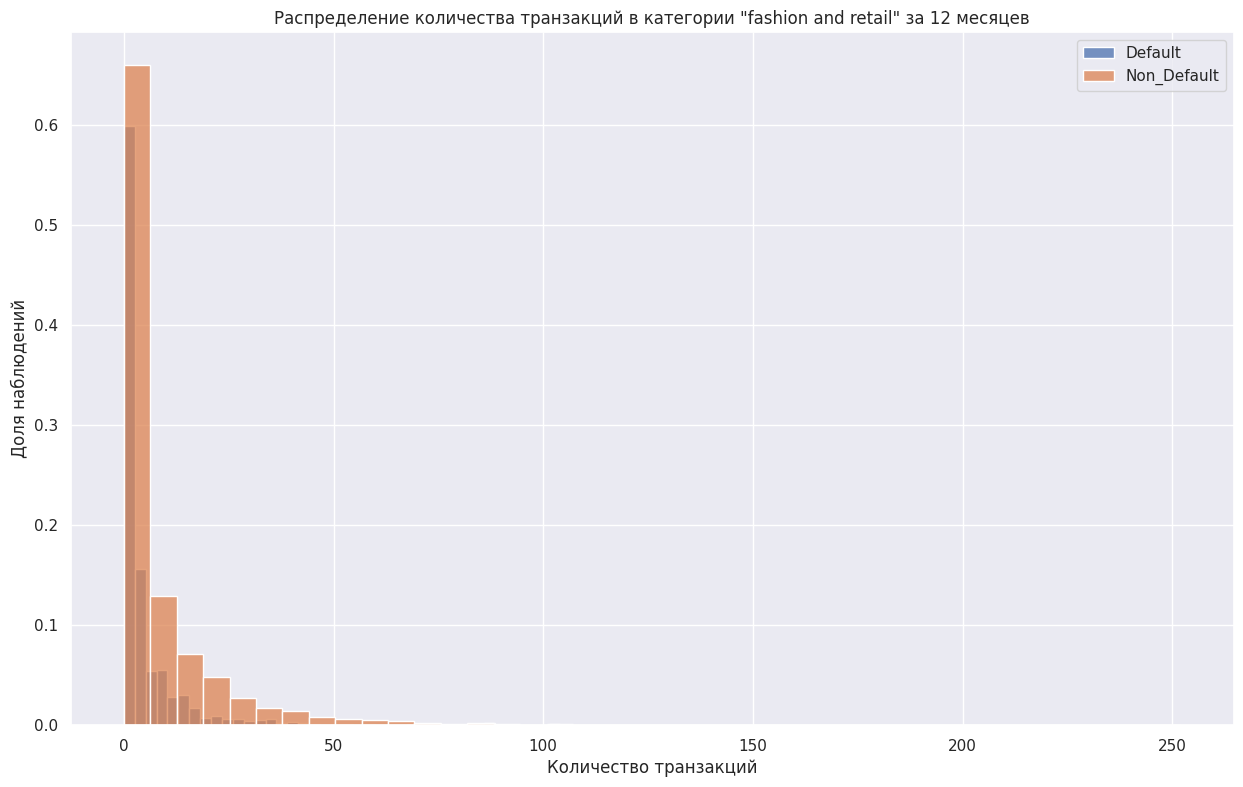

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='transactions_count_fashion_retail', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='transactions_count_fashion_retail', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение количества транзакций в категории "fashion and retail" за 12 месяцев')
plt.xlabel('Количество транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Распрределение напоминает предыдущий признак, и так же улучшается за счет сжатия (уже 3% значений сверху)

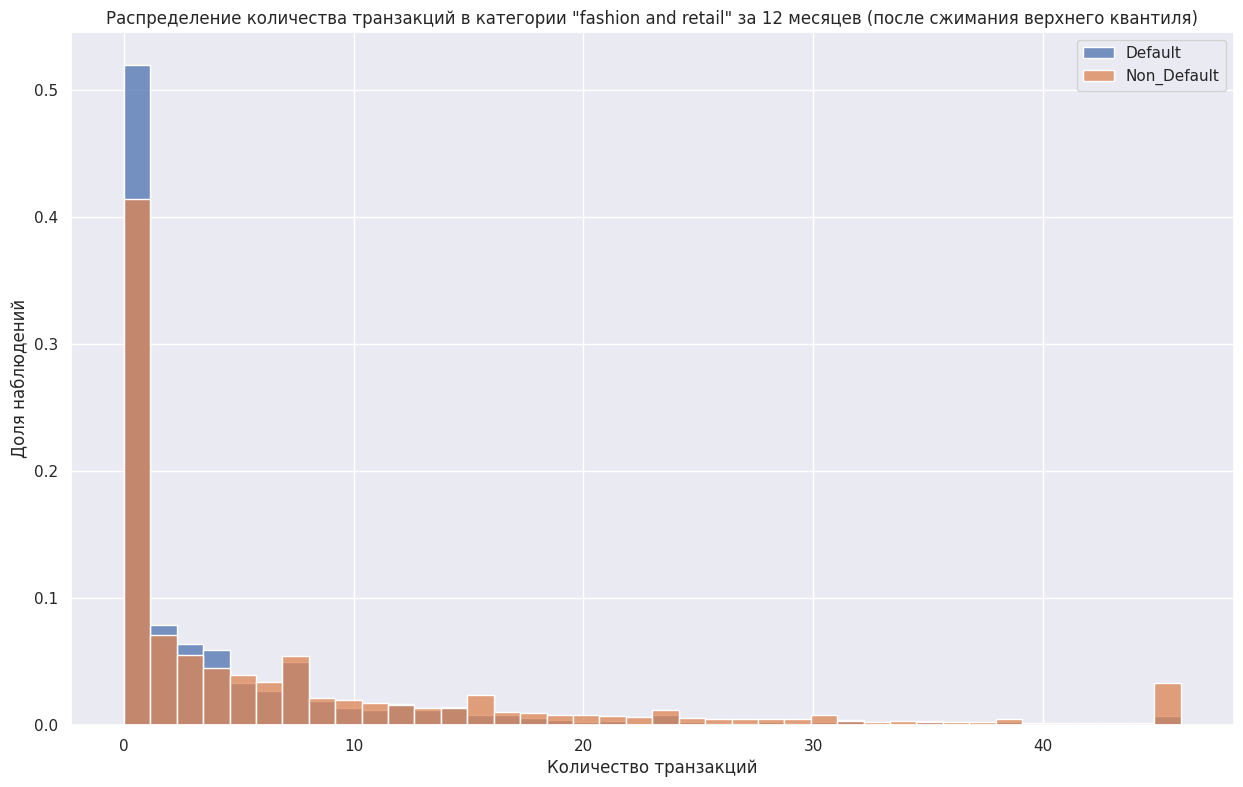

In [ ]:
X_train_mod = X_train['transactions_count_fashion_retail'].clip(0, X_train['transactions_count_fashion_retail'].quantile(0.97)).to_frame()

sns.histplot(data=X_train_mod.loc[y_train['target'] == 1], x='transactions_count_fashion_retail', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train_mod.loc[y_train['target'] == 0], x='transactions_count_fashion_retail', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение количества транзакций в категории "fashion and retail" за 12 месяцев (после сжимания верхнего квантиля)')
plt.xlabel('Количество транзакций')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

На получившемся графике явно видно, что при большом количестве транзакций шанс выйти в дефолт достаточно мал (т.е. весь дефолт "сосредотачивается" в небольшом числе транзакций

In [ ]:
boundaries['transactions_count_fashion_retail'] = (0, X_train['transactions_count_fashion_retail'].quantile(0.97))
X_train['transactions_count_fashion_retail'] = X_train_mod['transactions_count_fashion_retail']

get_iv('transactions_count_fashion_retail')

Исходный IV (без пропусков) -  0.12609


,Заполнитель,IV
0,Среднее,0.11451
1,Медиана,0.10712
2,Ноль,0.09919
3,Константа вне нижней границы значений,0.10504
4,Константа вне верхней границы значений,0.08094


И снова в качестве заполнителя пропусков выбирается среднее значение

In [ ]:
na_fillers['transactions_count_fashion_retail'] = X_train['transactions_count_fashion_retail'].mean()
filling_strategy['transactions_count_fashion_retail'] = 'mean'

##### age

Последний признак - возраст заемщика

In [ ]:
print(f"Доля пропусков - {X_train['age'].isna().sum() / X_train.shape[0]:.2f}")

Доля пропусков - 0.02


In [ ]:
X_train['age'].describe()

,age
count,88018.000000
mean,16.444067
std,8.811731
min,-2.206708
25%,9.497604
50%,15.572895
75%,23.419576
max,100.465435


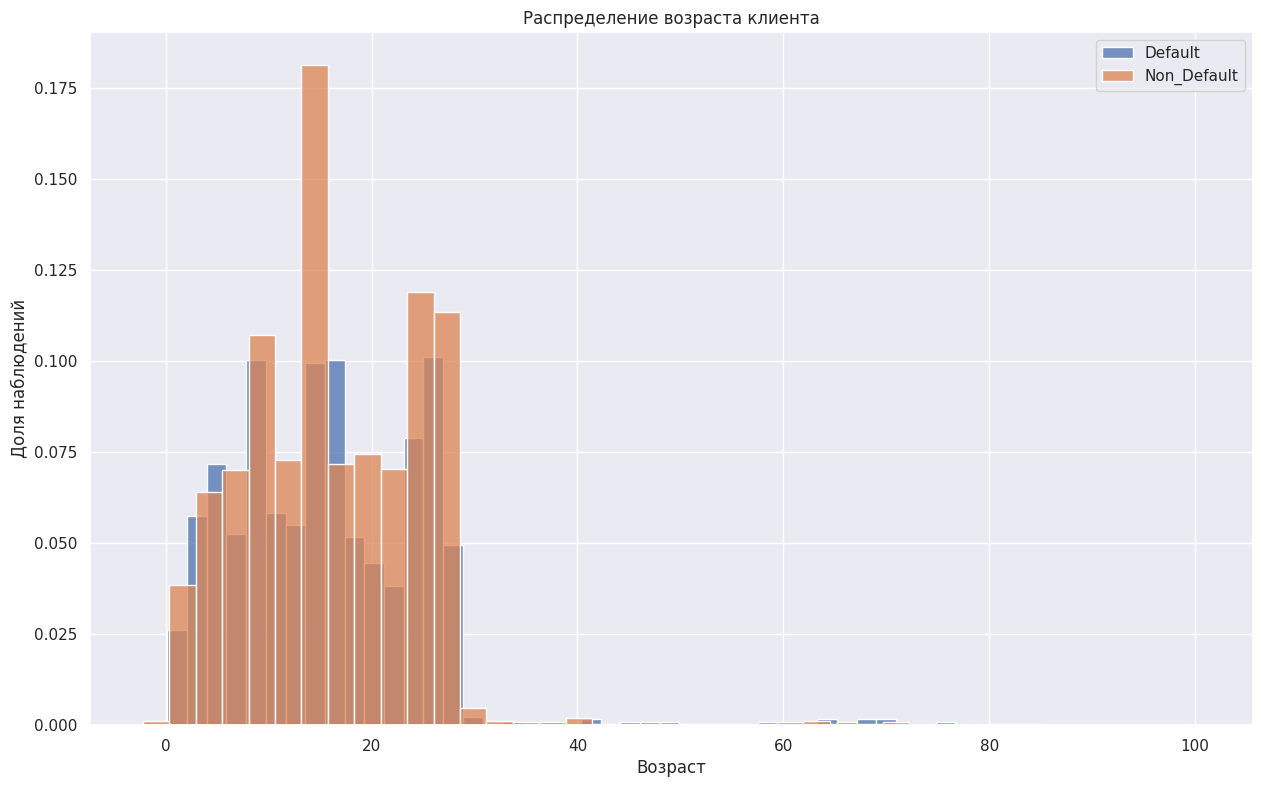

In [ ]:
sns.histplot(data=X_train.loc[y_train['target'] == 1], x='age', stat='probability', bins=40, label='Default')
sns.histplot(data=X_train.loc[y_train['target'] == 0], x='age', stat='probability', bins=40, label='Non_Default')
plt.title('Распределение возраста клиента')
plt.xlabel('Возраст')
plt.ylabel('Доля наблюдений')
plt.legend()

plt.show()

Вообще, распределение данного признака выглядит крайне странным: во первых, более половины всех значений меньше 18, что выглядит явно странно; во-вторых, присутствуют и отрицательные величины, что просто абсурдно. В добавок есть и небольшой процент пропущенных значений. Да и по гистограмме явно не отслеживается какой-либо существенный паттерн поведения целевой переменной от возраста. Наконец, показатель IV у признака крайне низкий (порядка 0.02).


Все это говорит в пользу исключения данного признака из рассмотрения как "мусорного"

Cложно отработать, пока что лучше отказаться от возраста (+ инфы не так чтобы много)

In [ ]:
na_fillers.pop('age', None)

#### Итог по признакам (заполнение + стандартизация)

В итоге, в результате последовательного анализа, получаем следующий картину по признакам:



*   **max_card_utilization** - сохраняем признак, сжатий не производим, пропуски заполняем средним;
*   **overdue_ratio** - сохраняем признак, сжатий не производим, пропуски заполняем средним;
*   **min_balance_amount** - сохраняем признак, сжимаем сверху до 99 квантиля, пропуски заполняем медианой;
*   **avg_balance_amount** - сохраняем признак, сжатий не производим, пропуски заполняем 0;
*   **total_income_3m** - сохраняем признак, сжимаем сверху до 97 квантиля, пропуски заполняем средним;
*   **max_deposit_amount_5y** - убираем признак;
*   **transactions_sum_medicine** - убираем признак;
*   **income_transactions_sum** - сохраняем признак, сжимаем сверху до 97 квантиля, пропуски заполняем средним;
*   **transactions_sum_cash** - убираем признак;
*   **transactions_sum_supermarkets** - сохраняем признак, сжимаем сверху до 98 квантиля, пропуски заполняем медианой;
*   **loan_count** - сохраняем признак, сжимаем сверху до 99 квантиля, пропуски заполняем средним;
*   **transactions_count_cash_services** - сохраняем признак, сжимаем сверху до 99 квантиля, пропуски заполняем средним;
*   **transactions_count_fashion_retail** - сохраняем признак, сжимаем сверху до 97 квантиля, пропуски заполняем средним;
*   **loan_count** - убираем признак.


Кроме того, в сильных разных шкал у оставшихся признаков, необходимо перед построением произвести масштабирование признаков; для этого сделаем стандартизацию через ```StandardScaler```

In [ ]:
X_train_selected = X_train.loc[:, list(na_fillers.keys())].copy(deep=True)

for feature in na_fillers.keys():
    X_train_selected.loc[X_train_selected[feature].isna(), feature] = na_fillers[feature]

scaler = StandardScaler()
X_train_selected[:] = scaler.fit_transform(X_train_selected)

### Построение моделей

Опишем общую методологию всего процесса поиска наилучшей модели:

1. Подбирается оптимальное число фолдов для последующего подбора гиперпараметров на кросс-валидации. Для этого перебиралась различные варианты числа фолдов, производилась кросс-валидация логистической регрессии на заданном числе фолдов и строилась зависимость среднего roc-auc с доверительным интервалом
2. Находились оптимальные спецификация моделей. Рассматривались следующие варианты: логистическая регрессия (выступающая в качества бейзлайн-модели), метод ближайших соседей, решающие дерево, случайный лес, градиентный бустинг. Сама процедура поиска спецификации состояла в следующем:

  *   Для модели на всем признаковом пространстве, при помощи библиотеки ```optuna``` подбирались оптимальные гиперпарметры (целевая метрика - ROC-AUC). Таким образом, получалась **базовая спецификация** модели;
  *   Для полученой базовой спецификации производился отбор признаков при помощи stepwise-подхода (включение/исключение признаков происходит на основании изменения метрики ROC-AUC) - это призвано повысить обобщающую способность модели;
  *   На отобранном признаковом пространстве вновь производился подбор гиперпараметров, получаю **альтернативную спецификацию**;
  *   На основании результатов кросс-валидации делался выбор **финальной спецификации** (если альтернативная не сильно хуже базовой, то выбиралась она; иначе выбор останавливался на базовой);
  *   Наконец, для финальной спецификации производился подбор оптимального трешхолда с точки зрения максимизации f1 (последовательным перебором трешхолдов и усреднением результатов кросс-валидации). Оптимальный трешхолд использовался для получения итоговых величин метрик Precision, Recall, F1, а также считался ROC-AUC (опять же, все рассчитывалось на кросс-валидации)

3. На последнем этапе строился один стэкинг: три наилучших рассматривались в качестве базовых, на основании их скоров обучался метаалгоритм-логистическая регрессия. Базовые модели брались в своих базовых спецификациях (то есть построенные на всех признаках), для метаалгоритма только подбирались гиперпараметры через ```optuna```. Затем так же подбирался трешхолд и снимались показатели метрик.

4. Сравнение всех подходов, выбор наилучшего


#### Подбор числа фолдов для кросс-валидации

In [ ]:
def get_cv_res(model, X, y, cv_nums, alpha=0.05):
    """
    Функция для проведения кросс-валидация с разным числом фолдов, с расчетом средней
    величины ROC-AUC и доверительного интервала для нее (через t-статистику)
    """
    res_mean = []
    res_ub = []
    res_lb = []
    for n in cv_nums:
        t_crit = sps.t.ppf(1 - alpha / 2, df=n-1, loc=0, scale=1)
        res = cross_val_score(model, X, y, scoring='roc_auc', cv=n)
        mean, var = res.mean(), np.sqrt(res.var(ddof=1))

        res_mean.append(mean)
        res_ub.append(mean + t_crit * var / n)
        res_lb.append(mean - t_crit * var / n)

    return res_mean, res_ub, res_lb

In [ ]:
def plot_cv_res(mean, ub, lb, cv_nums, model_name):
    """
    Функция для отрисовки графика изменения метрики на кросс-валидации
    """
    plt.plot(cv_nums, mean, color='red', label='Среднее значение ROC-AUC')
    plt.plot(cv_nums, ub, color='cyan')
    plt.plot(cv_nums, lb, color='cyan')
    plt.fill_between(cv_nums, lb, ub, color = 'cyan', alpha=0.3, label='95% доверительный интервал')

    plt.xticks(cv_nums)
    plt.yticks(np.linspace(0.7, 0.8, 10))
    plt.xlabel('Количество фолдов на кросс-валидации')
    plt.ylabel('ROC-AUC')
    plt.title(f'График зависимости метрики ROC-AUC на кросс-валидации для {model_name}')
    plt.legend()

    plt.show()

In [ ]:
logreg = LogisticRegression()
cv_nums = list(range(2, 30))
res_mean, res_ub, res_lb = get_cv_res(logreg, X_train_selected, y_train['target'], cv_nums)

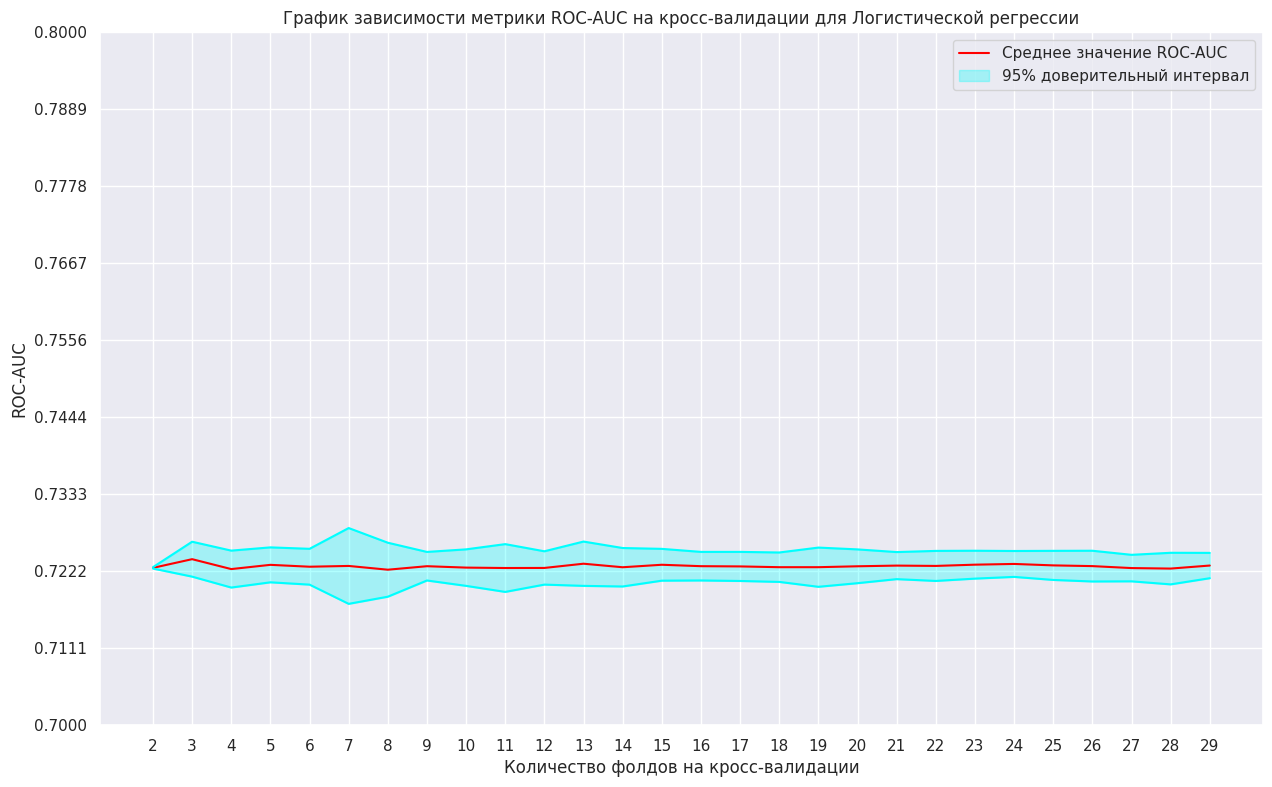

In [ ]:
plot_cv_res(res_mean, res_ub, res_lb, cv_nums, 'Логистической регрессии')

По графику видно, что начиная примерно с 20 фолдов уже не происходит резких расширений доверительного интервала и скачков в средней величине. Так что везде далее для кросс-валидации будет использоваться 20 фолдов

In [ ]:
n_best = 20

#### Обучение моделей

In [ ]:
# По ходу рассмотрения моделей сразу будем запоминать метрики для каждой из них

results_train = {
    'Model': [],
    'Threshold': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC-AUC': [],
}

##### Общий функционал

In [ ]:
def stepwise(df, target, base_model, n=n_best, alpha_in=0.00001, alpha_out=0.000001):
    """
    Функция, реализующая отбор признаков по stepwise-алгоритму
    """

    selected_features = []
    features = set(df.columns)
    y = target.values
    # Исходный roc-auc на модели с константами
    score = cross_val_score(base_model, np.ones((df.shape[0], 1)), y, scoring='roc_auc', cv=n).mean()

    while True:
        # forward:
        best_feature = None
        max_add = alpha_in # Здесь будет лежать максимальная надбавка на текущей итерации
        if (len(selected_features) < len(features)):
            # Цикл по еще не добавленным признакам
            for feature in features - set(selected_features):
                # Посчитали roc-auc на валидации
                cur_score = cross_val_score(base_model, df[selected_features + [feature]], y, scoring='roc_auc', cv=n).mean()

                # Если текущая надбавка лучше, то запоминаем признак и надбавку
                if cur_score - score > max_add:
                    max_add = cur_score - score
                    best_feature = feature

            # Ввел else, чтобы было понимание правильной работы алгоритма
            if best_feature:
                score += max_add
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, новый ROC-AUC: {round(score, 6)}")
            else:
                print(f"В модель ничего не было добавлено")

        # backward
        worst_feature = None
        min_loss = alpha_out # Здесь будет лежать минимальная потеря на текущей итерации
        if (len(selected_features) > 1):
            for feature in selected_features:
                # Отбираем все признаки, кроме одного
                cur_features = [i for i in selected_features if i != feature]

                # Посчитали roc-auc на валидации
                cur_score = cross_val_score(base_model, df[cur_features], y, scoring='roc_auc', cv=n).mean()

                # Если текущая потеря меньше, то запоминаем признак и потерю
                if score - cur_score < min_loss:
                    min_loss = score - cur_score
                    worst_feature = feature

            # Ввел else, чтобы было понимание правильной работы алгоритма
            if worst_feature:
                score -= min_loss
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, новый ROC-AUC: {round(score, 6)}")
            else:
                print(f"Из модели ничего не было исключено")

        # Если на итерации ничего не добавили и не удалили, то выходим
        if not (best_feature or worst_feature):
            break

    return selected_features

In [ ]:
def find_optimal_threshold(model, X, y, n=n_best):
    """
    Подбор оптимальной величины трешхолда, с точки зрения f1
    """
    opt_threshold = 0
    opt_f1 = 0

    for threshold in np.arange(0.01, 1, 0.05):
        f1s = []
        skf = StratifiedKFold(n_splits=n).split(X, y)
        for train_index, test_index in skf:
            model.fit(X.iloc[train_index], y.iloc[train_index])
            scores = model.predict_proba(X.iloc[test_index])[:, 1]
            f1s.append(f1_score(y.iloc[test_index], np.where(scores > threshold, 1, 0)))

        cur_f1 = np.array(f1s).mean()

        if cur_f1 > opt_f1:
            opt_f1 = cur_f1
            opt_threshold = threshold

        if cur_f1 == 0 and opt_f1 > 0:
            break

    return round(opt_threshold, 2)

In [ ]:
def update_results(model, X, y, threshold, model_name, n=n_best):
    """
    Добавление значений метрик для каждой модели
    """
    results_train['Model'].append(model_name)
    results_train['Threshold'].append(threshold)
    rc = []
    pr = []
    re = []
    f1 = []

    skf = StratifiedKFold(n_splits=n).split(X, y)

    for train_index, test_index in skf:
        model.fit(X.iloc[train_index], y.iloc[train_index])
        scores = model.predict_proba(X.iloc[test_index])[:, 1]
        answ = np.where(scores > threshold, 1, 0)

        rc.append(roc_auc_score(y.iloc[test_index], scores))
        pr.append(precision_score(y.iloc[test_index], answ))
        re.append(recall_score(y.iloc[test_index], answ))
        f1.append(f1_score(y.iloc[test_index], answ))

    results_train['ROC-AUC'].append(np.array(rc).mean())
    results_train['Precision'].append(np.array(pr).mean())
    results_train['Recall'].append(np.array(re).mean())
    results_train['F1'].append(np.array(f1).mean())

##### Логистическая регрессия (baseline)

In [ ]:
selected_features_logreg = list(X_train_selected.columns)

In [ ]:
def objective_logreg(trial):
    """
    Функция для подбора гиперпараметров LogReg с помощью optuna
    """
    params = {
        'C': trial.suggest_float('C', 0.01, 1)
    }

    auc_valid = cross_val_score(LogisticRegression(**params), X_train_selected.loc[:, selected_features_logreg], y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_logreg, n_trials=40)

[I 2025-01-13 13:06:55,551] A new study created in memory with name: no-name-87cc5df2-f7bc-4967-bc20-f7d81f6e7fb8
[I 2025-01-13 13:06:59,145] Trial 0 finished with value: 0.7229459893677794 and parameters: {'C': 0.6537947303003497}. Best is trial 0 with value: 0.7229459893677794.
[I 2025-01-13 13:07:03,418] Trial 1 finished with value: 0.723004940990148 and parameters: {'C': 0.17480183676027425}. Best is trial 1 with value: 0.723004940990148.
[I 2025-01-13 13:07:08,124] Trial 2 finished with value: 0.7229436935265537 and parameters: {'C': 0.8198150980082269}. Best is trial 1 with value: 0.723004940990148.
[I 2025-01-13 13:07:14,830] Trial 3 finished with value: 0.7234716256467973 and parameters: {'C': 0.026175977918593385}. Best is trial 3 with value: 0.7234716256467973.
[I 2025-01-13 13:07:20,839] Trial 4 finished with value: 0.7229403409504861 and parameters: {'C': 0.9225315147781012}. Best is trial 3 with value: 0.7234716256467973.
[I 2025-01-13 13:07:24,621] Trial 5 finished with v

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'C': 0.010182248797688805}


In [ ]:
selected_features_logreg = stepwise(X_train_selected, y_train['target'], LogisticRegression(**study.best_params), n_best)

В модель была добавлена переменная overdue_ratio, новый ROC-AUC: 0.676039
В модель была добавлена переменная max_card_utilization, новый ROC-AUC: 0.698702
Из модели ничего не было исключено
В модель была добавлена переменная transactions_count_fashion_retail, новый ROC-AUC: 0.71284
Из модели ничего не было исключено
В модель была добавлена переменная transactions_count_cash_services, новый ROC-AUC: 0.716665
Из модели ничего не было исключено
В модель была добавлена переменная loan_count, новый ROC-AUC: 0.719958
Из модели ничего не было исключено
В модель была добавлена переменная transactions_sum_supermarkets, новый ROC-AUC: 0.722879
Из модели ничего не было исключено
В модель была добавлена переменная min_balance_amount, новый ROC-AUC: 0.724285
Из модели ничего не было исключено
В модель ничего не было добавлено
Из модели ничего не было исключено


In [ ]:
selected_features_logreg

['overdue_ratio',
 'max_card_utilization',
 'transactions_count_fashion_retail',
 'transactions_count_cash_services',
 'loan_count',
 'transactions_sum_supermarkets',
 'min_balance_amount']

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_logreg, n_trials=20)

[I 2025-01-13 13:12:25,871] A new study created in memory with name: no-name-e56e678f-6fe6-4054-8d0d-eade80750527
[I 2025-01-13 13:12:28,207] Trial 0 finished with value: 0.7234464780242524 and parameters: {'C': 0.06019397259392269}. Best is trial 0 with value: 0.7234464780242524.
[I 2025-01-13 13:12:30,408] Trial 1 finished with value: 0.7232264360993097 and parameters: {'C': 0.36113381691905194}. Best is trial 0 with value: 0.7234464780242524.
[I 2025-01-13 13:12:32,688] Trial 2 finished with value: 0.7232438351316567 and parameters: {'C': 0.8584306429799007}. Best is trial 0 with value: 0.7234464780242524.
[I 2025-01-13 13:12:36,160] Trial 3 finished with value: 0.7232443635983985 and parameters: {'C': 0.8998251478779624}. Best is trial 0 with value: 0.7234464780242524.
[I 2025-01-13 13:12:39,348] Trial 4 finished with value: 0.7232209452202731 and parameters: {'C': 0.5552486833234416}. Best is trial 0 with value: 0.7234464780242524.
[I 2025-01-13 13:12:41,495] Trial 5 finished with

In [ ]:
print(f'Гиперпараметры для модели на отобранных признаках - {study.best_params}')

Гиперпараметры для модели на отобранных признаках - {'C': 0.012380277163419457}


Видно, что значение ROC-AUC на кросс-валидации не сильно меньше базовой, так что в качестве финальной спецификации логистической регрессии будем использовать альтернативную

In [ ]:
final_logreg = LogisticRegression(**study.best_params)
threshold = find_optimal_threshold(final_logreg, X_train_selected.loc[:, selected_features_logreg], y_train['target'])
update_results(
    final_logreg,
    X_train_selected.loc[:, selected_features_logreg],
    y_train['target'],
    threshold,
    'Логистическая регрессия',
)

##### Метод ближайших соседей

In [ ]:
selected_features_knn = list(X_train_selected.columns)

In [ ]:
def objective_knn(trial):
    """
    Функция для подбора гиперпараметров KNN с помощью optuna
    """
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 30),
        'p': trial.suggest_float('p', 1, 10),
        'weights': 'distance',
        'n_jobs': -1
    }

    auc_valid = cross_val_score(KNeighborsClassifier(**params), X_train_selected.loc[:, selected_features_knn], y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=20)

[I 2025-01-13 08:05:09,232] A new study created in memory with name: no-name-4ac718ba-feb1-4053-96c2-46a7c4bf893c
[I 2025-01-13 08:12:23,633] Trial 0 finished with value: 0.6405339260582033 and parameters: {'n_neighbors': 29, 'p': 6.364513666900138}. Best is trial 0 with value: 0.6405339260582033.
[I 2025-01-13 08:18:58,884] Trial 1 finished with value: 0.6220870434570664 and parameters: {'n_neighbors': 21, 'p': 8.759349017992381}. Best is trial 0 with value: 0.6405339260582033.
[I 2025-01-13 08:25:51,124] Trial 2 finished with value: 0.6302000335227353 and parameters: {'n_neighbors': 24, 'p': 6.441767132622287}. Best is trial 0 with value: 0.6405339260582033.
[I 2025-01-13 08:31:40,369] Trial 3 finished with value: 0.589615214839263 and parameters: {'n_neighbors': 12, 'p': 5.78269017656738}. Best is trial 0 with value: 0.6405339260582033.
[I 2025-01-13 08:38:33,195] Trial 4 finished with value: 0.5852174598744468 and parameters: {'n_neighbors': 9, 'p': 2.2272371872502132}. Best is tri

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'n_neighbors': 30, 'p': 3.8565442413969198}


In [ ]:
selected_features_knn = stepwise(X_train_selected, y_train['target'], KNeighborsClassifier(**study.best_params), n_best)

В модель была добавлена переменная overdue_ratio, новый ROC-AUC: 0.57891
В модель была добавлена переменная max_card_utilization, новый ROC-AUC: 0.609787
Из модели ничего не было исключено
В модель была добавлена переменная transactions_sum_supermarkets, новый ROC-AUC: 0.629454
Из модели ничего не было исключено
В модель была добавлена переменная min_balance_amount, новый ROC-AUC: 0.631077
Из модели ничего не было исключено
В модель была добавлена переменная avg_balance_amount, новый ROC-AUC: 0.63356
Из модели ничего не было исключено
В модель ничего не было добавлено
Из модели ничего не было исключено


In [ ]:
selected_features_knn

['overdue_ratio',
 'max_card_utilization',
 'transactions_sum_supermarkets',
 'min_balance_amount',
 'avg_balance_amount']

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=10)

[I 2025-01-13 11:45:34,590] A new study created in memory with name: no-name-e8b63222-355e-40e6-bfd4-e0dd36ffd3f1
[I 2025-01-13 11:46:21,881] Trial 0 finished with value: 0.5750577363025806 and parameters: {'n_neighbors': 7, 'p': 1.1015746460278344}. Best is trial 0 with value: 0.5750577363025806.
[I 2025-01-13 11:46:49,891] Trial 1 finished with value: 0.5599165492565061 and parameters: {'n_neighbors': 5, 'p': 4.616569003156524}. Best is trial 0 with value: 0.5750577363025806.
[I 2025-01-13 11:47:28,061] Trial 2 finished with value: 0.5984337861998649 and parameters: {'n_neighbors': 14, 'p': 7.444290987562102}. Best is trial 2 with value: 0.5984337861998649.
[I 2025-01-13 11:47:58,985] Trial 3 finished with value: 0.5665064111625225 and parameters: {'n_neighbors': 6, 'p': 3.7034979752289887}. Best is trial 2 with value: 0.5984337861998649.
[I 2025-01-13 11:48:45,745] Trial 4 finished with value: 0.6316674277139669 and parameters: {'n_neighbors': 22, 'p': 6.386595092640926}. Best is tr

In [ ]:
print(f'Гиперпараметры для модели на отобранных признаках - {study.best_params}')

Гиперпараметры для модели на отобранных признаках - {'n_neighbors': 30, 'p': 6.394178394305976}


Альтернативная спецификация показала качество несколько лучше базовой, значит использовать будем ее

In [ ]:
final_knn = KNeighborsClassifier(**study.best_params)
threshold = find_optimal_threshold(final_knn, X_train_selected.loc[:, selected_features_knn], y_train['target'])
update_results(
    final_knn,
    X_train_selected.loc[:, selected_features_knn],
    y_train['target'],
    threshold,
    'Метод ближайших соседей',
)

##### Решающее дерево

In [ ]:
selected_features_dt = list(X_train_selected.columns)

In [ ]:
def objective_dt(trial):
    """
    Функция для подбора гиперпараметров DecisionTree с помощью optuna
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 20, 300),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 300)
    }

    auc_valid = cross_val_score(DecisionTreeClassifier(**params), X_train_selected.loc[:, selected_features_dt], y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=40)

[I 2025-01-13 12:24:33,212] A new study created in memory with name: no-name-d66e31d7-90ec-4b84-bcba-f5ddb59fd9a8
[I 2025-01-13 12:25:16,525] Trial 0 finished with value: 0.6800346176062256 and parameters: {'max_depth': 29, 'min_samples_split': 268, 'min_samples_leaf': 258}. Best is trial 0 with value: 0.6800346176062256.
[I 2025-01-13 12:25:55,772] Trial 1 finished with value: 0.6737972116789654 and parameters: {'max_depth': 18, 'min_samples_split': 83, 'min_samples_leaf': 199}. Best is trial 0 with value: 0.6800346176062256.
[I 2025-01-13 12:26:17,407] Trial 2 finished with value: 0.6829073785991798 and parameters: {'max_depth': 12, 'min_samples_split': 224, 'min_samples_leaf': 237}. Best is trial 2 with value: 0.6829073785991798.
[I 2025-01-13 12:26:43,043] Trial 3 finished with value: 0.6542013892764952 and parameters: {'max_depth': 22, 'min_samples_split': 267, 'min_samples_leaf': 64}. Best is trial 2 with value: 0.6829073785991798.
[I 2025-01-13 12:27:07,626] Trial 4 finished wit

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'max_depth': 25, 'min_samples_split': 173, 'min_samples_leaf': 295}


In [ ]:
selected_features_dt = stepwise(X_train_selected, y_train['target'], DecisionTreeClassifier(**study.best_params), n_best)

В модель была добавлена переменная overdue_ratio, новый ROC-AUC: 0.632472
В модель была добавлена переменная max_card_utilization, новый ROC-AUC: 0.674898
Из модели ничего не было исключено
В модель была добавлена переменная transactions_sum_supermarkets, новый ROC-AUC: 0.69082
Из модели ничего не было исключено
В модель ничего не было добавлено
Из модели ничего не было исключено


In [ ]:
selected_features_dt

['overdue_ratio', 'max_card_utilization', 'transactions_sum_supermarkets']

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=20)

[I 2025-01-13 13:00:14,270] A new study created in memory with name: no-name-d0c8d3a6-9069-45ad-9319-b05d2a664b48
[I 2025-01-13 13:00:23,544] Trial 0 finished with value: 0.6898056917521405 and parameters: {'max_depth': 25, 'min_samples_split': 168, 'min_samples_leaf': 293}. Best is trial 0 with value: 0.6898056917521405.
[I 2025-01-13 13:00:33,051] Trial 1 finished with value: 0.6669045183388735 and parameters: {'max_depth': 21, 'min_samples_split': 245, 'min_samples_leaf': 175}. Best is trial 0 with value: 0.6898056917521405.
[I 2025-01-13 13:00:39,655] Trial 2 finished with value: 0.6730335716444946 and parameters: {'max_depth': 27, 'min_samples_split': 139, 'min_samples_leaf': 192}. Best is trial 0 with value: 0.6898056917521405.
[I 2025-01-13 13:00:47,663] Trial 3 finished with value: 0.6489417786174162 and parameters: {'max_depth': 24, 'min_samples_split': 246, 'min_samples_leaf': 93}. Best is trial 0 with value: 0.6898056917521405.
[I 2025-01-13 13:00:55,922] Trial 4 finished wi

In [ ]:
print(f'Гиперпараметры для модели на отобранных признаках - {study.best_params}')

Гиперпараметры для модели на отобранных признаках - {'max_depth': 16, 'min_samples_split': 215, 'min_samples_leaf': 300}


Видно, что оптимальное значение ROC-AUC на кросс-валидации несколько улучшилось, следовательной финальной спецификацией для решающего дерева будем использовать альтерантивную

In [ ]:
final_dt = DecisionTreeClassifier(**study.best_params)
threshold = find_optimal_threshold(final_dt, X_train_selected.loc[:, selected_features_dt], y_train['target'])
update_results(
    final_dt,
    X_train_selected.loc[:, selected_features_dt],
    y_train['target'],
    threshold,
    'Решающее дерево',
)

##### Случайный лес

In [ ]:
selected_features_rf = list(X_train_selected.columns)

In [ ]:
def objective_rf(trial):
    """
    Функция для подбора гиперпараметров RandomForest с помощью optuna
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.99),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'subsample_freq': trial.suggest_int('subsample_freq', 30, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'boosting_type': 'rf',
        'n_jobs': -1
    }

    auc_valid = cross_val_score(LGBMClassifier(**params, verbosity=-1), X_train_selected.loc[:, selected_features_rf], y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=40)

[I 2025-01-14 08:12:47,594] A new study created in memory with name: no-name-1e4e7c78-980a-402f-b6a5-fee34b0fb7c4
[I 2025-01-14 08:13:13,265] Trial 0 finished with value: 0.7397077821245461 and parameters: {'max_depth': 12, 'min_child_samples': 270, 'num_leaves': 59, 'learning_rate': 0.5814735697571495, 'n_estimators': 110, 'subsample_freq': 34, 'colsample_bytree': 0.7845579348592171}. Best is trial 0 with value: 0.7397077821245461.
[I 2025-01-14 08:13:28,884] Trial 1 finished with value: 0.7510714350222677 and parameters: {'max_depth': 12, 'min_child_samples': 236, 'num_leaves': 111, 'learning_rate': 0.9217175307702988, 'n_estimators': 51, 'subsample_freq': 45, 'colsample_bytree': 0.5207987493834159}. Best is trial 1 with value: 0.7510714350222677.
[I 2025-01-14 08:14:05,855] Trial 2 finished with value: 0.7321193630003339 and parameters: {'max_depth': 10, 'min_child_samples': 53, 'num_leaves': 104, 'learning_rate': 0.586564523409723, 'n_estimators': 127, 'subsample_freq': 41, 'colsam

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'max_depth': 16, 'min_child_samples': 119, 'num_leaves': 133, 'learning_rate': 0.28378080167836955, 'n_estimators': 146, 'subsample_freq': 48, 'colsample_bytree': 0.6321015364105363}


In [ ]:
selected_features_rf = stepwise(X_train_selected, y_train['target'], LGBMClassifier(**study.best_params, boosting_type='rf', verbosity=-1), n_best)

В модель была добавлена переменная overdue_ratio, новый ROC-AUC: 0.647569
В модель была добавлена переменная max_card_utilization, новый ROC-AUC: 0.699308
Из модели ничего не было исключено
В модель ничего не было добавлено
Из модели ничего не было исключено


In [ ]:
selected_features_rf

['overdue_ratio', 'max_card_utilization']

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=20)

[I 2025-01-14 08:57:10,376] A new study created in memory with name: no-name-e75d6d6f-1218-4ecb-9a2b-d2c1a12cf9fd
[I 2025-01-14 08:57:23,275] Trial 0 finished with value: 0.7061236753544684 and parameters: {'max_depth': 5, 'min_child_samples': 107, 'num_leaves': 82, 'learning_rate': 0.3980283269774313, 'n_estimators': 158, 'subsample_freq': 36, 'colsample_bytree': 0.5342406944819044}. Best is trial 0 with value: 0.7061236753544684.
[I 2025-01-14 08:57:29,761] Trial 1 finished with value: 0.7013607211978653 and parameters: {'max_depth': 10, 'min_child_samples': 220, 'num_leaves': 86, 'learning_rate': 0.5227734817772981, 'n_estimators': 55, 'subsample_freq': 44, 'colsample_bytree': 0.7136256443180564}. Best is trial 0 with value: 0.7061236753544684.
[I 2025-01-14 08:57:41,697] Trial 2 finished with value: 0.7031307448945772 and parameters: {'max_depth': 7, 'min_child_samples': 101, 'num_leaves': 99, 'learning_rate': 0.5154337657278917, 'n_estimators': 99, 'subsample_freq': 40, 'colsample

In [ ]:
print(f'Гиперпараметры для модели на отобранных признаках - {study.best_params}')

Гиперпараметры для модели на отобранных признаках - {'max_depth': 5, 'min_child_samples': 256, 'num_leaves': 45, 'learning_rate': 0.8012320447989634, 'n_estimators': 103, 'subsample_freq': 43, 'colsample_bytree': 0.6114051955841888}


Здесь альтернативная спецификация показала результат значительно хуже базовой, значит лучше будет строить случайный лес на всех признаках

In [ ]:
selected_features_rf = list(X_train_selected.columns)
best_params = {
    'max_depth': 16,
    'min_child_samples': 119,
    'num_leaves': 133,
    'learning_rate': 0.28378080167836955,
    'n_estimators': 146,
    'subsample_freq': 48,
    'colsample_bytree': 0.6321015364105363
}

In [ ]:
final_rf = LGBMClassifier(**best_params, boosting_type='rf', verbosity=-1)
threshold = find_optimal_threshold(final_rf, X_train_selected.loc[:, selected_features_rf], y_train['target'])
update_results(
    final_rf,
    X_train_selected.loc[:, selected_features_rf],
    y_train['target'],
    threshold,
    'Случайный лес',
)

##### Градиентный бустинг

In [ ]:
selected_features_gb = list(X_train_selected.columns)

In [ ]:
def objective_gb(trial):
    """
    Функция для подбора гиперпараметров GradientBoosting с помощью optuna
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'subsample_freq': trial.suggest_int('subsample_freq', 30, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'boosting_type': 'gbdt',
        'n_jobs': -1
    }

    auc_valid = cross_val_score(LGBMClassifier(**params, verbosity=-1), X_train_selected.loc[:, selected_features_gb], y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gb, n_trials=40)

[I 2025-01-14 09:10:48,361] A new study created in memory with name: no-name-5dc1dd7a-548a-4b1d-ba72-5a699fbb15a7
[I 2025-01-14 09:11:33,688] Trial 0 finished with value: 0.7430008229981879 and parameters: {'max_depth': 7, 'min_child_samples': 133, 'num_leaves': 36, 'learning_rate': 0.06471595825917349, 'n_estimators': 239, 'subsample_freq': 34, 'colsample_bytree': 0.8295329033805342}. Best is trial 0 with value: 0.7430008229981879.
[I 2025-01-14 09:12:10,246] Trial 1 finished with value: 0.7534917680390356 and parameters: {'max_depth': 11, 'min_child_samples': 131, 'num_leaves': 84, 'learning_rate': 0.030868433559100735, 'n_estimators': 133, 'subsample_freq': 45, 'colsample_bytree': 0.5673065735002907}. Best is trial 1 with value: 0.7534917680390356.
[I 2025-01-14 09:12:42,014] Trial 2 finished with value: 0.728320439691896 and parameters: {'max_depth': 5, 'min_child_samples': 157, 'num_leaves': 106, 'learning_rate': 0.18945381771433198, 'n_estimators': 203, 'subsample_freq': 33, 'col

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'max_depth': 9, 'min_child_samples': 88, 'num_leaves': 32, 'learning_rate': 0.02054951811704546, 'n_estimators': 190, 'subsample_freq': 42, 'colsample_bytree': 0.8800399771008246}


In [ ]:
selected_features_gb = stepwise(X_train_selected, y_train['target'], LGBMClassifier(**study.best_params, boosting_type='gbdt', verbosity=-1), n_best)

В модель была добавлена переменная overdue_ratio, новый ROC-AUC: 0.662604
В модель была добавлена переменная max_card_utilization, новый ROC-AUC: 0.707181
Из модели ничего не было исключено
В модель была добавлена переменная transactions_count_fashion_retail, новый ROC-AUC: 0.722465
Из модели ничего не было исключено
В модель была добавлена переменная min_balance_amount, новый ROC-AUC: 0.734364
Из модели ничего не было исключено
В модель была добавлена переменная transactions_count_cash_services, новый ROC-AUC: 0.741634
Из модели ничего не было исключено
В модель была добавлена переменная loan_count, новый ROC-AUC: 0.747513
Из модели ничего не было исключено
В модель была добавлена переменная total_income_3m, новый ROC-AUC: 0.749911
Из модели ничего не было исключено
В модель была добавлена переменная avg_balance_amount, новый ROC-AUC: 0.75713
Из модели ничего не было исключено
В модель была добавлена переменная transactions_sum_supermarkets, новый ROC-AUC: 0.7577
Из модели ничего не б

In [ ]:
selected_features_gb

['overdue_ratio',
 'max_card_utilization',
 'transactions_count_fashion_retail',
 'min_balance_amount',
 'transactions_count_cash_services',
 'loan_count',
 'total_income_3m',
 'avg_balance_amount',
 'transactions_sum_supermarkets']

In [ ]:
# тут почему-то лог удалился, честно подбирал так же как и раньше (перезапускать не стал для честности)
study = optuna.create_study(direction='maximize')
study.optimize(objective_gb, n_trials=20)

In [ ]:
print(f'Гиперпараметры для модели на отобранных признаках - {study.best_params}')

Гиперпараметры для модели на отобранных признаках - {'max_depth': 11, 'min_child_samples': 240, 'num_leaves': 131, 'learning_rate': 0.017684374716226664, 'n_estimators': 98, 'subsample_freq': 43, 'colsample_bytree': 0.5069220042677256}


После отбора признаков мы не получили сильной потери в качестве на кросс-валидации, так что будем использовать альтарнативную спецификацию

In [ ]:
final_gb = LGBMClassifier(**study.best_params, boosting_type='gbdt', verbosity=-1)
threshold = find_optimal_threshold(final_gb, X_train_selected.loc[:, selected_features_gb], y_train['target'])
update_results(
    final_gb,
    X_train_selected.loc[:, selected_features_gb],
    y_train['target'],
    threshold,
    'Градиентный бустинг',
)

#### Стекинг

Наилучшее качество среди базовых моделей продемонстрировли бустинг, случайный лес и логистическая регрессия; так что будем строить стэкинг на основе их прогнозов

In [ ]:
# Здесь идут параметры для базовых специфкаций
params_logreg = {'C': 0.010182248797688805}
params_rf = {
    'max_depth': 16,
    'min_child_samples': 119,
    'num_leaves': 133,
    'learning_rate': 0.28378080167836955,
    'n_estimators': 146,
    'subsample_freq': 48,
    'colsample_bytree': 0.6321015364105363
}
params_gb = {
    'max_depth': 9,
    'min_child_samples': 88,
    'num_leaves': 32,
    'learning_rate': 0.02054951811704546,
    'n_estimators': 190,
    'subsample_freq': 42,
    'colsample_bytree': 0.8800399771008246
}

logreg = LogisticRegression(**params_logreg)
rf = LGBMClassifier(**params_rf, boosting_type='rf', verbosity=-1)
gb = LGBMClassifier(**params_gb, boosting_type='gbdt', verbosity=-1)

logreg.fit(X_train_selected, y_train['target'])
rf.fit(X_train_selected, y_train['target'])
gb.fit(X_train_selected, y_train['target'])

In [ ]:
# Составляем признаковое пространство из скоров трех моделей
logreg_pred = logreg.predict_proba(X_train_selected)[:, 1]
rf_pred = rf.predict_proba(X_train_selected)[:, 1]
gb_pred = gb.predict_proba(X_train_selected)[:, 1]

X_meta = pd.DataFrame(data={'lr_score': logreg_pred, 'rf_score': rf_pred, 'gb_score': gb_pred})

X_meta.head()

,lr_score,rf_score,gb_score
0,0.006572,0.009655,0.006381
1,0.009510,0.009099,0.004909
2,0.026593,0.037579,0.037770
3,0.009174,0.010971,0.006825
4,0.014963,0.022719,0.046031


In [ ]:
def objective_stacking(trial):
    """
    Функция для подбора гиперпараметров для Stacking через Logreg с помощью optuna
    """
    params = {
        'C': trial.suggest_float('C', 0.01, 1)
    }

    auc_valid = cross_val_score(LogisticRegression(**params), X_meta, y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_stacking, n_trials=40)

[I 2025-01-14 11:57:03,861] A new study created in memory with name: no-name-e484a275-777b-4226-861a-c2909b59dc6a
[I 2025-01-14 11:57:06,346] Trial 0 finished with value: 0.901404049736058 and parameters: {'C': 0.1876856747869764}. Best is trial 0 with value: 0.901404049736058.
[I 2025-01-14 11:57:09,019] Trial 1 finished with value: 0.9050558017282068 and parameters: {'C': 0.6301167362354916}. Best is trial 1 with value: 0.9050558017282068.
[I 2025-01-14 11:57:14,462] Trial 2 finished with value: 0.9047886726727302 and parameters: {'C': 0.5536261085968504}. Best is trial 1 with value: 0.9050558017282068.
[I 2025-01-14 11:57:18,186] Trial 3 finished with value: 0.9052304233965544 and parameters: {'C': 0.7035294096746104}. Best is trial 3 with value: 0.9052304233965544.
[I 2025-01-14 11:57:20,823] Trial 4 finished with value: 0.9056385581824211 and parameters: {'C': 0.9590889736575927}. Best is trial 4 with value: 0.9056385581824211.
[I 2025-01-14 11:57:23,515] Trial 5 finished with val

In [ ]:
print(f'Гиперпараметры для модели на всех признаках - {study.best_params}')

Гиперпараметры для модели на всех признаках - {'C': 0.9967571335975509}


In [ ]:
stack = LogisticRegression(**study.best_params)
threshold = find_optimal_threshold(stack, X_meta, y_train['target'])
update_results(
    stack,
    X_meta,
    y_train['target'],
    threshold,
    'Стэкинг',
)

#### Итог по обучению моделей

In [ ]:
res_df = pd.DataFrame(data=results_train)
res_df.set_index('Model', inplace=True)

res_df

,Threshold,Precision,Recall,F1,ROC-AUC
Model,,,,,
Логистическая регрессия,0.06,0.070419,0.056959,0.062633,0.724155
Метод ближайших соседей,0.06,0.038492,0.242079,0.066405,0.643165
Решающее дерево,0.06,0.049189,0.117091,0.069092,0.692215
Случайный лес,0.06,0.059075,0.245938,0.095207,0.754363
Градиентный бустинг,0.06,0.081436,0.057788,0.067441,0.756137
Стэкинг,0.06,0.318299,0.316947,0.316763,0.905672


Стоит отметить, что опимальный трешхолд везде получился одинаковым, поэтому все метрики можно спокойно сравнивать между собой

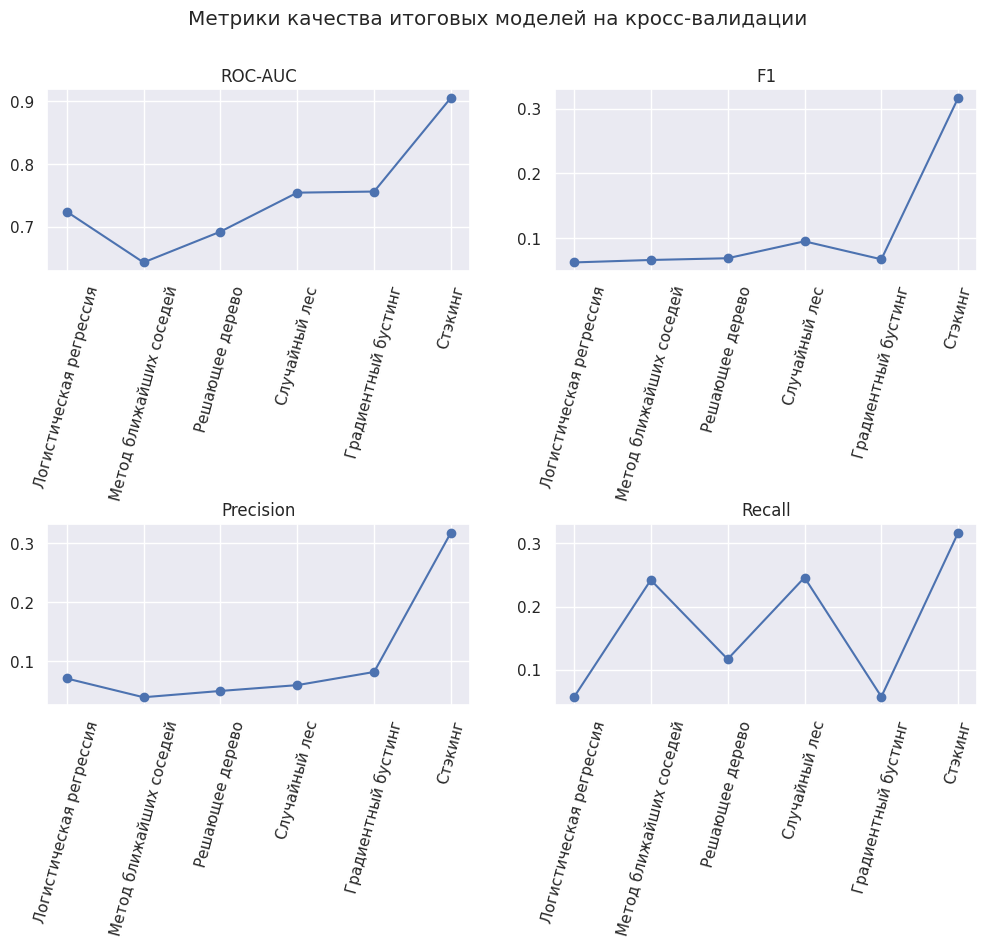

In [ ]:
plt.figure(figsize=(12, 8))
plt.suptitle('Метрики качества итоговых моделей на кросс-валидации')

plt.subplot(3, 2, 1)
plt.title('ROC-AUC')
plt.plot(res_df['ROC-AUC'],  marker='o')
plt.xticks(rotation=75)

plt.subplot(3, 2, 2)
plt.title('F1')
plt.plot(res_df['F1'],  marker='o')
plt.xticks(rotation=75)

plt.subplot(3, 2, 5)
plt.title('Precision')
plt.plot(res_df['Precision'],  marker='o')
plt.xticks(rotation=75)

plt.subplot(3, 2, 6)
plt.title('Recall')
plt.plot(res_df['Recall'],  marker='o')
plt.xticks(rotation=75)

plt.show()

Проанализируем полученные результаты:


1. Метод ближайших соседей и решающее дерево показали достаточно низкие результаты и не смогли побить бейзлайн модель.
2. Стэкинг оказался явно переобученным; поэтому, не смотря на наилучшее качество по всем метрикам, его не следует брать в качестве итоговой модели.
3. Градиентный бустинг и случайный лес показали примерно равный результат по целевой метрике ROC-AUC. При этом, случайный лес выдал значительно больше по показателю полноты и f-мере, а градиентный бустинг - лишь по точности.

Поэтому, при прочих равных, в качестве итоговой модели целесообразно было бы выбрать **случайный лес**. Соответственно, его валидация и будет проведена в втором разделе

### Kaggle

В отдельный пункт решил вынести то, что подвязано на соревновании.


При выгрузке прогнозов всех озвученных выше моделей на тестовой выборке, наилучшее качество удалось получить на стэкинге (0.73379 на 70% доступных); при этом самое тупое расширение признакового пространства (то есть добавление возраста и признаков с кучей пропусков) позволило без особых заморочек получить 0.75060 на тех же 70%. Тем не менее, я все же не стал отказываться от методологии отбора признаков - я не могу представить, что где-либо в реальной практике включение признаков со столь большим объемом пропусков и откровенно мусорного показателя возраста не являлость бы преступлением против здравого смысла.

Тем не менее, для избежания возможных вопросов, касающихся результатов соревнования, я ниже привожу сам процесс подбора этой модели. Сама модель не будет даже упомянута на защите, поэтому я не стал приводить каких-либо подробных комментариев по ходу построения

In [ ]:
import copy

na_fillers_kaggle = copy.deepcopy(na_fillers)
na_fillers_kaggle['max_deposit_amount_5y'] = X_train['max_deposit_amount_5y'].mean()
na_fillers_kaggle['transactions_sum_medicine'] = X_train['transactions_sum_medicine'].mean()
na_fillers_kaggle['transactions_sum_cash'] = X_train['transactions_sum_cash'].mean()
na_fillers_kaggle['age'] = X_train['age'].mean()

In [ ]:
X_train_kaggle = X_train.loc[:, list(na_fillers_kaggle.keys())].copy(deep=True)
X_test_kaggle = X_test.loc[:, list(na_fillers_kaggle.keys())].copy(deep=True)

for feature in na_fillers_kaggle.keys():
    X_train_kaggle[feature] = X_train_kaggle[feature].clip(*boundaries[feature])
    X_test_kaggle[feature] = X_test_kaggle[feature].clip(*boundaries[feature])
    X_train_kaggle.loc[X_train_kaggle[feature].isna(), feature] = na_fillers_kaggle[feature]
    X_test_kaggle.loc[X_test_kaggle[feature].isna(), feature] = na_fillers_kaggle[feature]

scaler = StandardScaler()
X_train_kaggle[:] = scaler.fit_transform(X_train_kaggle)
X_test_kaggle[:] = scaler.transform(X_test_kaggle)

In [ ]:
def objective_gbk(trial):
    """
    Функция для подбора гиперпараметров GradientBoosting с помощью optuna
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'subsample_freq': trial.suggest_int('subsample_freq', 30, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'boosting_type': 'gbdt',
        'n_jobs': -1
    }

    auc_valid = cross_val_score(LGBMClassifier(**params, verbosity=-1), X_train_kaggle, y_train['target'],
                                scoring='roc_auc', cv=n_best).mean()

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gbk, n_trials=40)

[I 2025-01-14 13:17:33,061] A new study created in memory with name: no-name-15a3dd50-2132-4946-84bf-6129041691b7
[I 2025-01-14 13:19:07,827] Trial 0 finished with value: 0.7273820936564501 and parameters: {'max_depth': 10, 'min_child_samples': 276, 'num_leaves': 88, 'learning_rate': 0.1521497223028971, 'n_estimators': 118, 'subsample_freq': 36, 'colsample_bytree': 0.5335572684079359}. Best is trial 0 with value: 0.7273820936564501.
[I 2025-01-14 13:20:11,582] Trial 1 finished with value: 0.7285245210355985 and parameters: {'max_depth': 5, 'min_child_samples': 206, 'num_leaves': 120, 'learning_rate': 0.1816971293436897, 'n_estimators': 206, 'subsample_freq': 41, 'colsample_bytree': 0.5218280723685045}. Best is trial 1 with value: 0.7285245210355985.
[I 2025-01-14 13:22:01,934] Trial 2 finished with value: 0.7122516590074165 and parameters: {'max_depth': 7, 'min_child_samples': 76, 'num_leaves': 113, 'learning_rate': 0.17007746746584235, 'n_estimators': 246, 'subsample_freq': 31, 'colsa

In [ ]:
print(f'Гиперпараметры для модели - {study.best_params}')

Гиперпараметры для модели - {'max_depth': 7, 'min_child_samples': 250, 'num_leaves': 125, 'learning_rate': 0.030087714470058122, 'n_estimators': 163, 'subsample_freq': 50, 'colsample_bytree': 0.7605989657424193}


In [ ]:
gb_kaggle = LGBMClassifier(**study.best_params, boosting_type='gbdt', verbosity=-1)
gb_kaggle.fit(X_train_kaggle, y_train['target'])

In [ ]:
X_kaggle = pd.read_csv('X_test.csv')

pred = X_kaggle['index'].to_frame()

In [ ]:
X_kaggle = X_kaggle.loc[:, list(na_fillers_kaggle.keys())].copy(deep=True)

for feature in na_fillers_kaggle.keys():
    X_kaggle[feature] = X_kaggle[feature].clip(*boundaries[feature])
    X_kaggle.loc[X_kaggle[feature].isna(), feature] = na_fillers_kaggle[feature]

X_kaggle[:] = scaler.transform(X_kaggle)

In [ ]:
pred['target'] = gb_kaggle.predict_proba(X_kaggle)[:, 1]
pred.set_index('index', inplace=True)
pred.to_csv('kaggle.csv')

# 2. Валидация лучшей модели

Сперва необходимо обозначить отдельные аспекты проводимой валидации:

1. **Качественный анализ итоговой модели** - необходимо обозначить наиболее значимые для итоговой модели признаки (на их аккуратный сбор требуется обращать повышенное внимание для корректной работы), а так же по возможности выявить явно прослеживающиеся корреляционные зависимости, имплементированные в модели;

2. **Качественный анализ признаков** - обозначение логических паттернов для проверки качества данных, а так же простых (не статистических) проверок схожести признаков в выборках для обучения и контроля;

3. **Количественный анализ признаков** - обозначение некоторой группы проверок на сохранение распределение признаков (с точки зрения как предварительной обработки, так и перед непосредственной передачей в модель);

4. **Анализ работы модели** - изучение распределений скоров модели на обучающей и валидационной выборках (с визуализацией и использованием статистических тестов)

## Качественный анализ итоговой модели

Сперва вновь обучим отобранный случайный лес и посмотрим на внутренние инструменты визуализации значимости отдельных признаков - графики важности по Gain и Split

In [ ]:
params_rf = {
    'max_depth': 16,
    'min_child_samples': 119,
    'num_leaves': 133,
    'learning_rate': 0.28378080167836955,
    'n_estimators': 146,
    'subsample_freq': 48,
    'colsample_bytree': 0.6321015364105363
}
model = LGBMClassifier(**params_rf, boosting_type='rf', verbosity=-1)
model.fit(X_train_selected, y_train['target'])

LGBMClassifier(boosting_type='rf', colsample_bytree=0.6321015364105363,
               learning_rate=0.28378080167836955, max_depth=16,
               min_child_samples=119, n_estimators=146, num_leaves=133,
               subsample_freq=48, verbosity=-1)

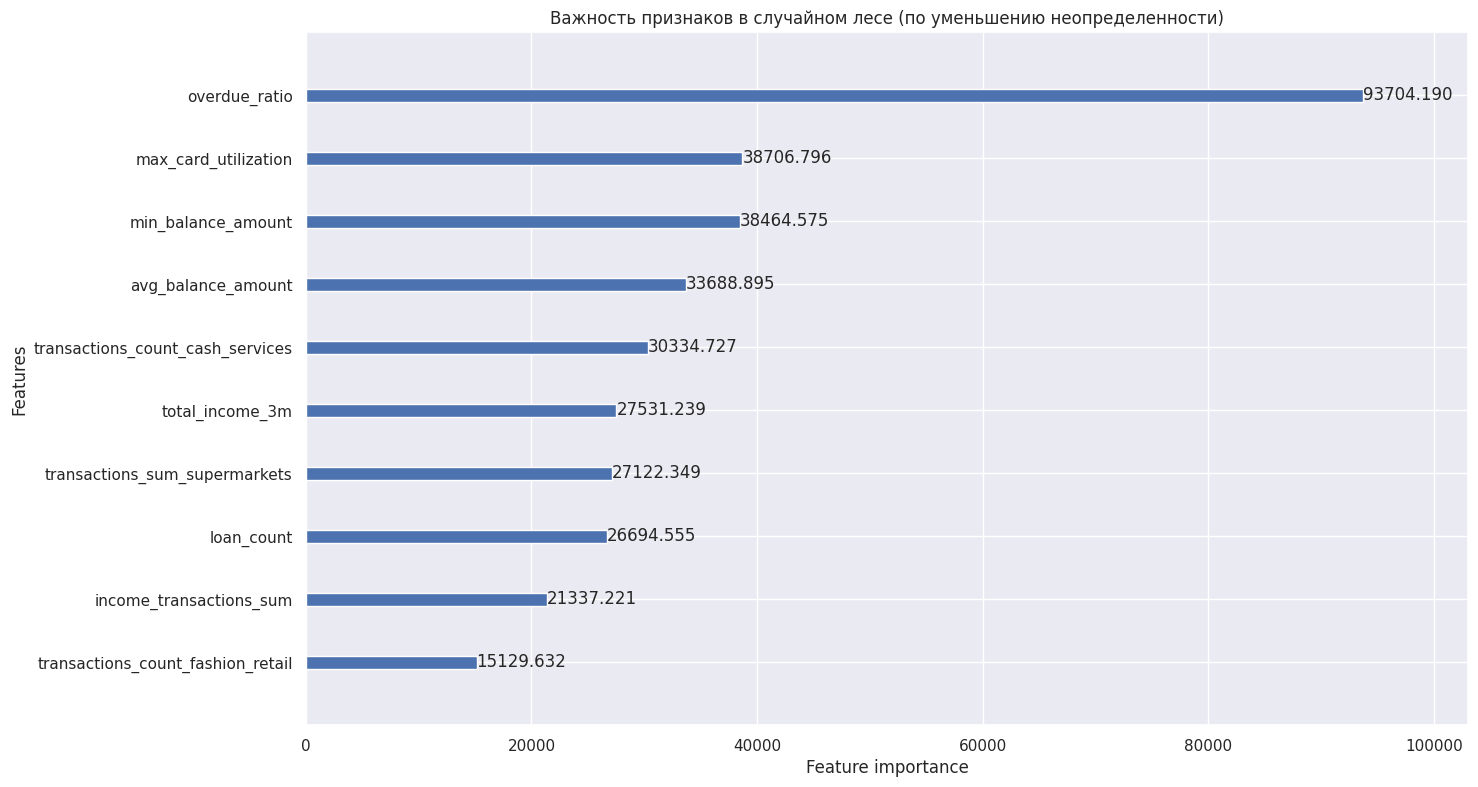

In [ ]:
plot_importance(model, importance_type="gain", title="Важность признаков в случайном лесе (по уменьшению неопределенности)")
plt.show()

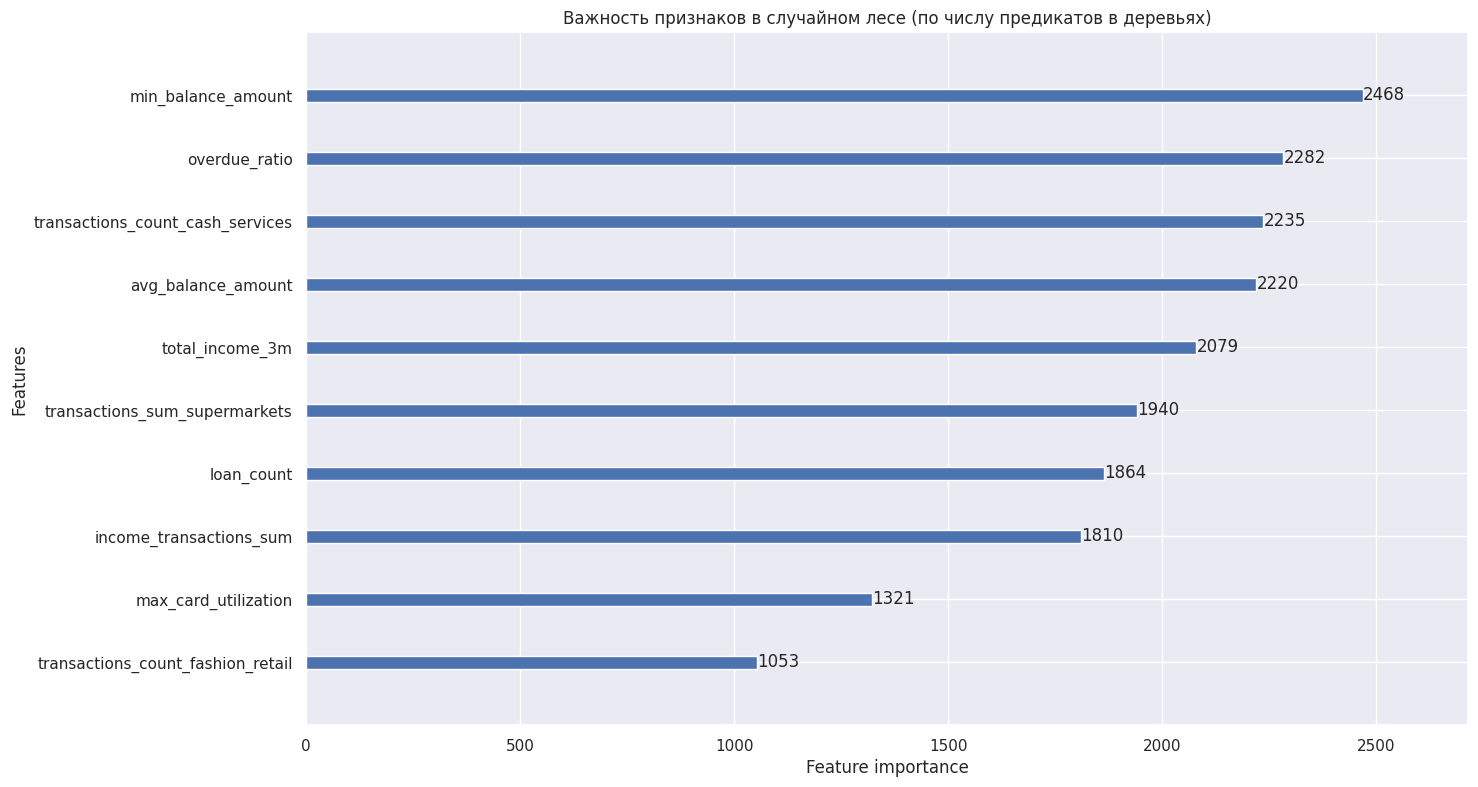

In [ ]:
plot_importance(model, importance_type="split", title="Важность признаков в случайном лесе (по числу предикатов в деревьях)")
plt.show()

Явно выделяется признак overdue_ratio, который дает существенную прибавку к Gain, и при этом достаточно часто происходит сплитование деревьев по нему. Другими достаточно важными признаками являются max_card_utilization (при этом сплитование по ней происходить не так уж часто), min_balance_amount и avg_balance_amount (важность по split у них так же достаточно высока). **К этим признакам следует уделять повышенное внимание** при первичном сборе данных и анализу стабильности (по максимуму избегать пропусков например)

С другой стороны, наименее значимым признаком в обоих контекстах является transactions_count_fashion_retail; относительно слабыми по обоим показателям являются и признаки income_transactions_sum и loan_count. Вполне можно ожидать, что **они в перспективе способны утратить значимость еще сильнее**, из-за чего придется несколько перестраивать модель

Для анализа корреляции признаков с событием дефолта построим график shap values

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_selected)

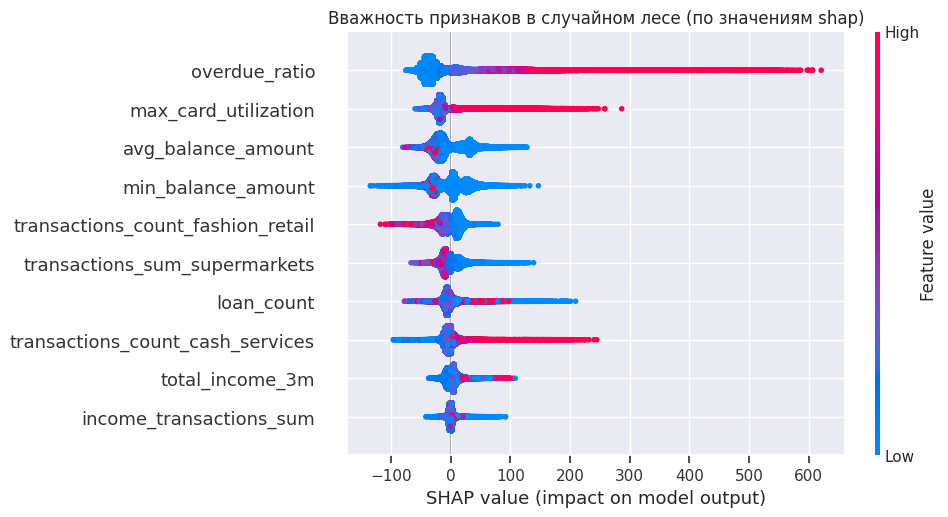

In [ ]:
plt.title('Вважность признаков в случайном лесе (по значениям shap)')
shap.plots.beeswarm(shap_values)
plt.show()

По графику shap values можно явно выделить ряд сильных корреляций признаков с дефолтом:

1. При сильном росте показателя overduе_ratio;
2. При росте max_card_utilization;
3. При убывании transactions_count_fashion_retail;
4. При росте transactions_count_cash_services.

В принципе, эти связи логичны, что докидывает очков доверия к модели

## Валидация признаков

### Качественная валидация

Сперва необходимо выделить естественные границы и тип данных для каждого признака, используемого в модели:

1. **max_card_utilization** - неотрицательное вещественное число (не может быть чересчур большим - т.е. значение 100 явно будет ложным);
2. **overdue_ratio** - вещественное число от 0 до 1;
3. **min_balance_amount** - неотрицательное вещественное число (точность десятичной дроби до 2-го знака (копейки) - дальше будет ошибкой);
4. **avg_balance_amount** - неотрицательное вещественное число (точность десятичной дроби до 2-го знака (копейки) - дальше будет ошибкой; не может быть меньше **min_balance_amount** буквально по определению);
5. **total_income_3m** - неотрицательное вещественное число (точность десятичной дроби до 2-го знака (копейки) - дальше будет ошибкой);;
6. **income_transactions_sum** - неотрицательное вещественное число (точность десятичной дроби до 2-го знака (копейки) - дальше будет ошибкой);
7. **transactions_sum_supermarkets** - неотрицательное вещественное число (точность десятичной дроби до 2-го знака (копейки) - дальше будет ошибкой);
8. **loan_count** - натуральное число;
9. **transactions_count_cash_services** - неотрицательное целое число;
10. **transactions_count_fashion_retail** - неотрицательное целое число.



Далее сравним обучающую и валидационную выборку в разрезе распределения дефолтов и долей пропусков по признакам

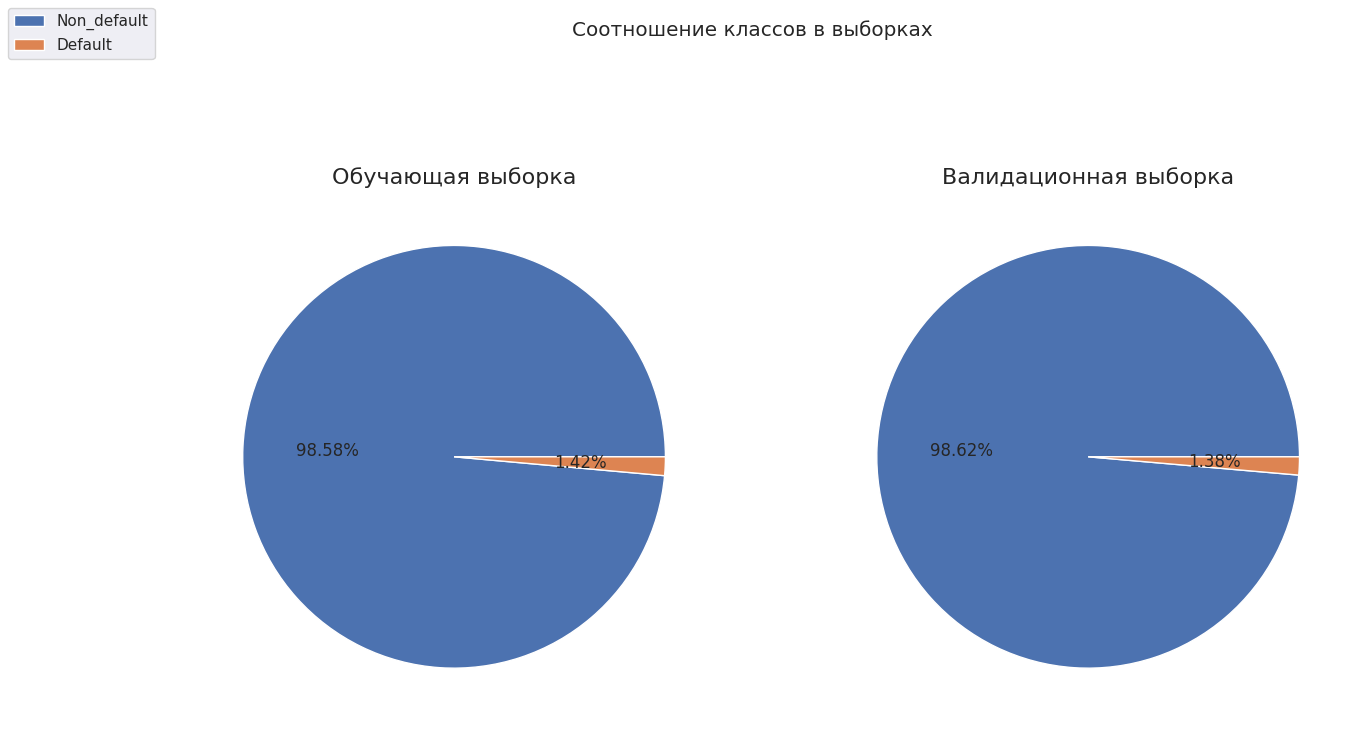

In [ ]:
plt.suptitle('Соотношение классов в выборках')

plt.subplot(1, 2, 1)

plt.title("Обучающая выборка", fontsize=16)
plt.pie(y_train.target.value_counts(), autopct="%0.2f%%")

plt.subplot(1, 2, 2)

plt.title("Валидационная выборка", fontsize=16)
plt.pie(y_test.target.value_counts(), autopct="%0.2f%%")

plt.figlegend(['Non_default', 'Default'], loc='upper left')
plt.show()

In [ ]:
df_null = pd.DataFrame(index = na_fillers.keys())

df_null['train'] = X_train[na_fillers.keys()].isna().sum() / X_train.shape[0]
df_null['validate'] = X_test[na_fillers.keys()].isna().sum() / X_test.shape[0]

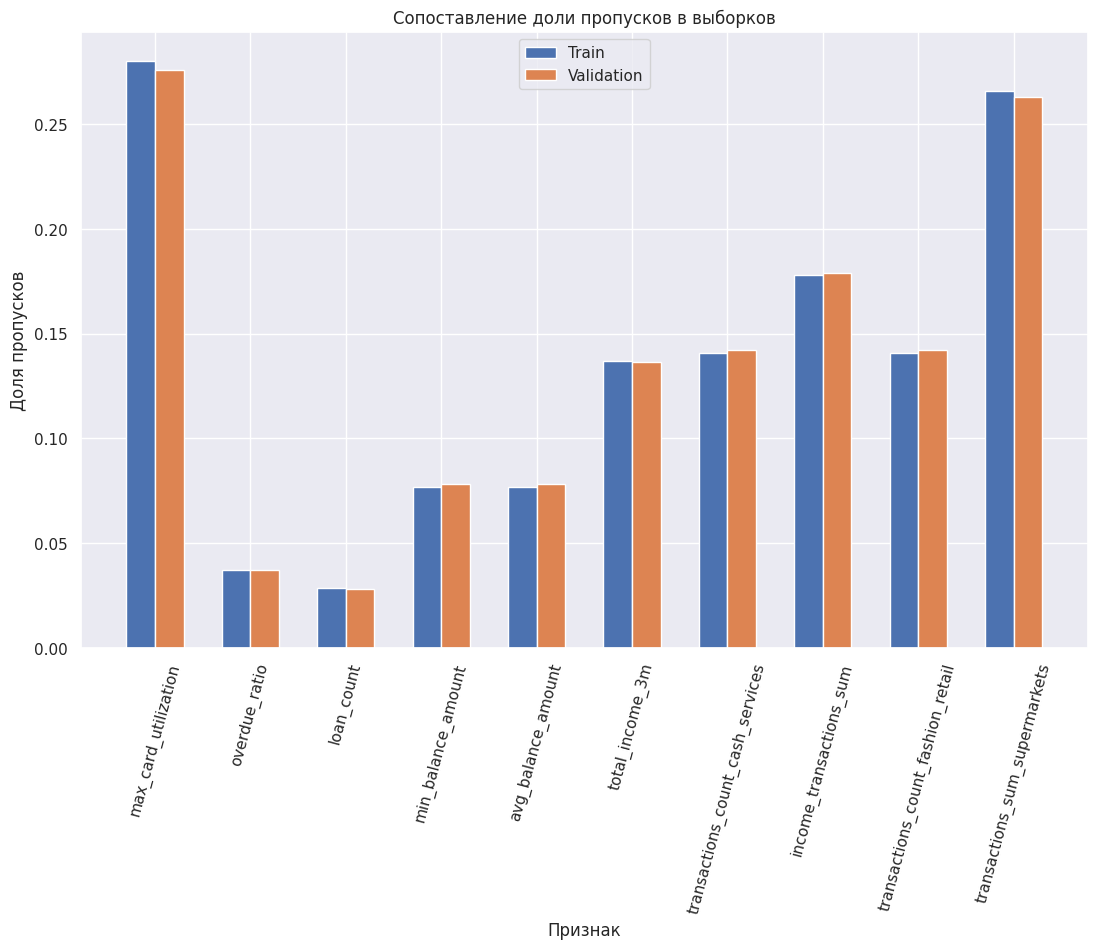

In [ ]:
plt.figure(figsize=(13, 8))
plt.title('Сопоставление доли пропусков в выборков')

x = np.arange(0, 10, 1)
w=0.3
plt.bar(x-w/2, df_null['train'], width=w, align='center', label='Train')
plt.bar(x+w/2, df_null['validate'], width=w, align='center', label='Validation')
plt.xlabel('Признак')
plt.ylabel('Доля пропусков')
plt.xticks(x, df_null.index, rotation=75)

plt.legend(loc='upper center')
plt.show()

В принципе, структура обучающей выборки в данных аспектах сохраняется и для валидационной

Наконец, необходимо удостовериться в отсутствии высокой степени интеркорреляции, причем как в обучающей, так и в валидационной выборках

In [ ]:
X_test_selected = X_test.loc[:, list(na_fillers.keys())].copy(deep=True)

for feature in na_fillers.keys():
    X_test_selected[feature] = X_test_selected[feature].clip(*boundaries[feature])
    X_test_selected.loc[X_test_selected[feature].isna(), feature] = na_fillers[feature]

X_test_selected[:] = scaler.transform(X_test_selected)

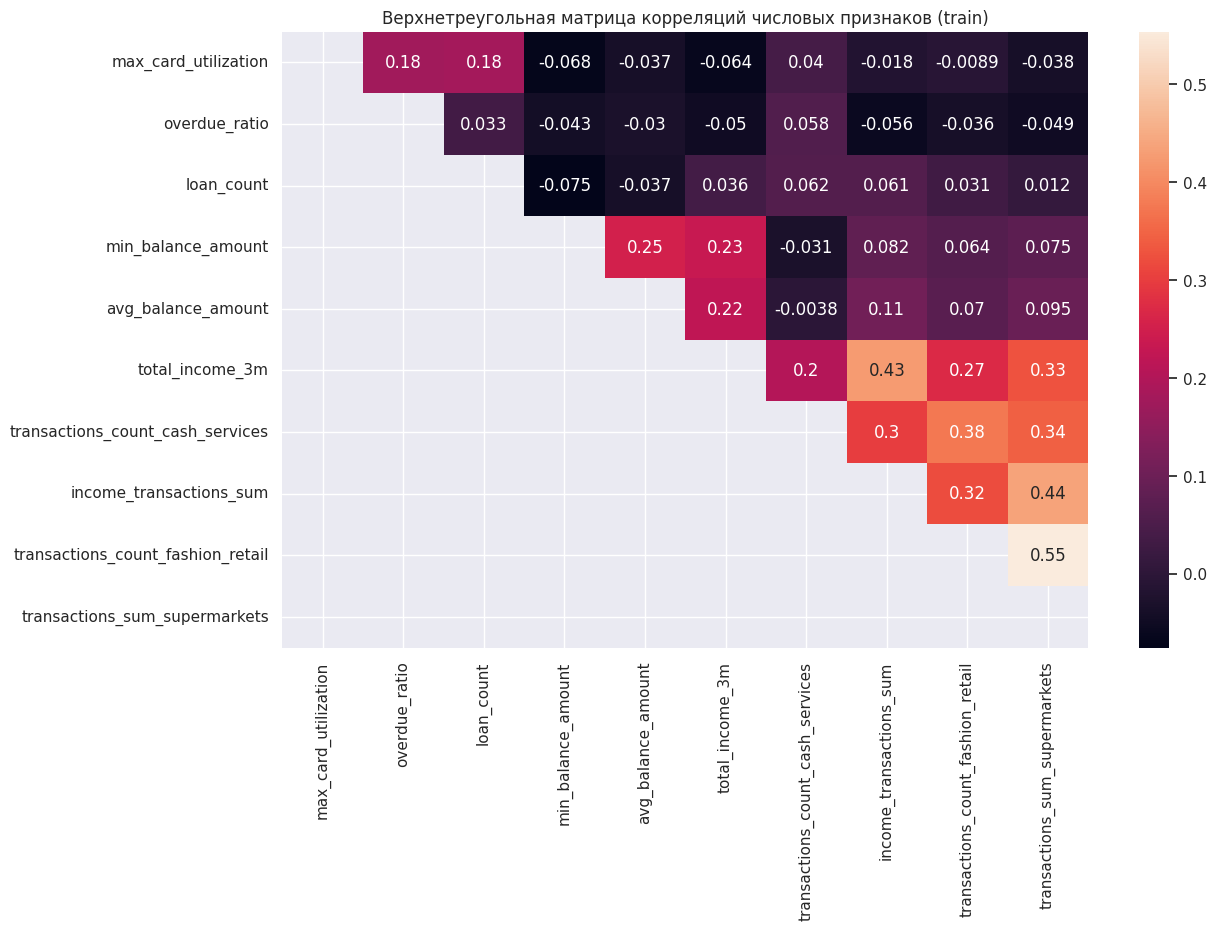

In [ ]:
plt.figure(figsize=(13, 8))

correlations = X_train_selected.corr()
sns.heatmap(correlations, annot=True, mask=np.tril(np.ones_like(correlations, dtype=bool)))
plt.title("Верхнетреугольная матрица корреляций числовых признаков (train)")

plt.show()

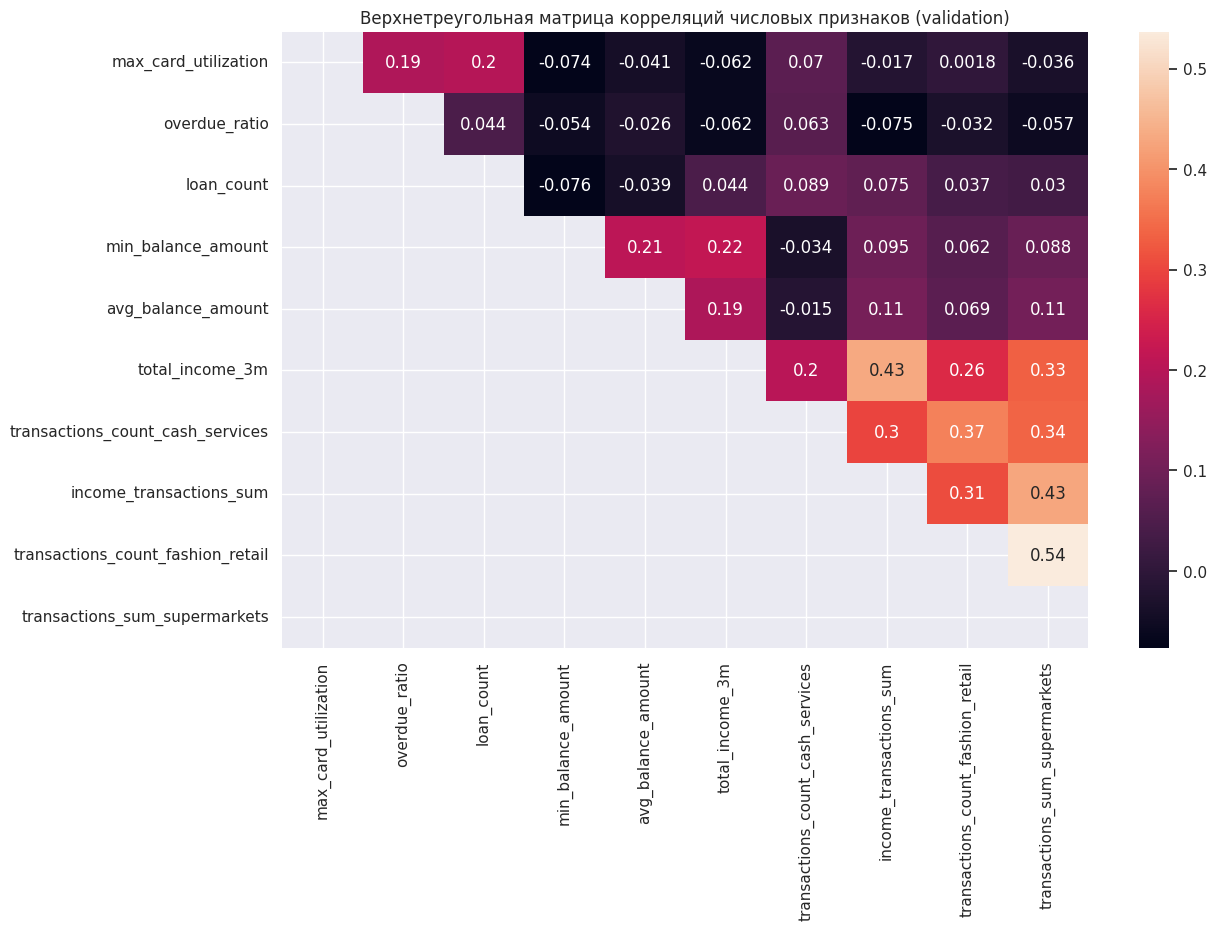

In [ ]:
plt.figure(figsize=(13, 8))

correlations = X_test_selected.corr()
sns.heatmap(correlations, annot=True, mask=np.tril(np.ones_like(correlations, dtype=bool)))
plt.title("Верхнетреугольная матрица корреляций числовых признаков (validation)")

plt.show()

Легко заметить, что коэффициенты корреляции не сильно отличаются и достаточно далеки от 1 (по модули); следовательно, интеркорреляция в признаках отсутствует

### Количественная валидация

Теперь при помощи некоторого статистического аппрата исследуем распределения признаков. Напомню, что над данными проводился следующий список преобразований:

* Сжатие верхнего квантиля (у всех кроме 3);
* Заполнение пропусков (у одного признака константой, у остальных - медианой или средним);
* Стандартизация признаков.

Таким образом, для каждого этапа можно предложить свои тесты на значимость таких преобразований:

* Квантильный тест на проверку совпадения требуемой квантили на выборках;
* Параметрические тесты для неконстантных заполнителей пропусков: t-тест для среднего и тест знаков для медианы;
* Непараметрические тесты для проверки схожести распределения: в качестве основного теста здесь был выбран критерий Колмогорова-Смирнова, в качестве support-теста - менее чувствительный тест Манна-Уитни (необходим для принятия решений при близких к критическому значениях p-value у основного теста)

Последний тест лучше проводить как в разрезе полной выборки, так и в разрезе дефолтников (их значительно меньше, чем недефолтников, а значит есть явный риск неотображения дрейфа распределений в этой категории при тестировании общей выборки).

Визуализация результатов тестов происходит при помощи столбчатых диаграмм для величин p-value. Для демонстрации использовался стандартный уровень значимости в 5%

In [ ]:
def quant_test_perform(feature):
    '''
    Функция для квантильного теста
    '''
    feat_t = X_test[feature]

    bound = boundaries[feature][1]
    # Если сжатий не производилось, то просто вернем 1
    return 1.0 if bound == np.inf else sps.quantile_test(feat_t.dropna(), q=bound, p=0.99, alternative='two-sided').pvalue

In [ ]:
def filler_test_perform(feature):
    '''
    Функция для тестирования значимости заполнителей
    '''
    feat_t = X_test[feature].clip(*boundaries[feature])

    filler = na_fillers[feature]
    filler_strategy = filling_strategy[feature]

    # Если заполняли константой, то просто вернем 1
    if filler_strategy == 'const':
        fill_p = 1.0
    elif filler_strategy == 'median':
        fill_p = sps.median_test(feat_t, X_train[feature], nan_policy='omit').pvalue
    else:
        fill_p = sps.ttest_ind(feat_t, X_train[feature], nan_policy='omit').pvalue

    return fill_p

In [ ]:
def distr_test_perform(feature, group=None):
    """
    Функция для тестирования схожести распределений признаков
    """
    # group позволяет переключать тест с общей выборки на отдельную группу (дефолт/не дефолт)
    if group:
        feat_c = X_train_selected.loc[y_train['target'] == group, feature]
        feat_t = X_test_selected.loc[y_test['target'] == group, feature]
    else:
        feat_c = X_train_selected[feature]
        feat_t = X_test_selected[feature]

    ks_p = sps.kstest(feat_t, feat_c).pvalue
    mw_p = sps.mannwhitneyu(feat_t, feat_c).pvalue

    return ks_p, mw_p

In [ ]:
data = {
    'quant_p': [],
    'filler_p': [],
    'ks_p (all)': [],
    'mw_p (all)': [],
    'ks_p (def)': [],
    'mw_p (def)': [],
}

for feature in X_train_selected.columns:
    data['quant_p'].append(quant_test_perform(feature))
    data['filler_p'].append(filler_test_perform(feature))

    ks_p, mw_p = distr_test_perform(feature)
    data['ks_p (all)'].append(ks_p)
    data['mw_p (all)'].append(mw_p)

    ks_p, mw_p = distr_test_perform(feature, group=1)
    data['ks_p (def)'].append(ks_p)
    data['mw_p (def)'].append(mw_p)

df_tests = pd.DataFrame(data=data, index=X_train_selected.columns)

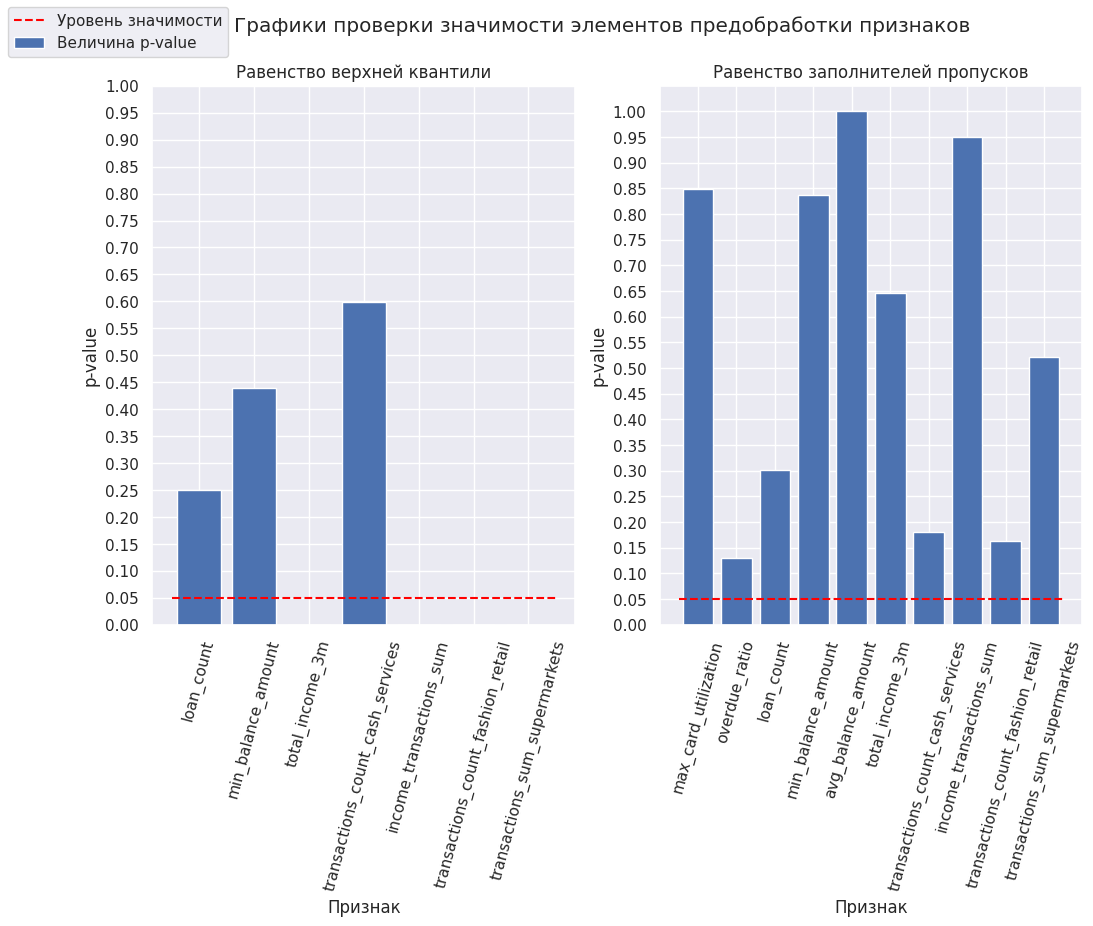

In [ ]:
plt.figure(figsize=(12, 7))

plt.suptitle('Графики проверки значимости элементов предобработки признаков')

plt.subplot(1, 2, 1)
plt.title('Равенство верхней квантили')
plt.bar(df_tests[df_tests['quant_p'] < 1].index, df_tests.loc[df_tests['quant_p'] < 1, 'quant_p'], label='Величина p-value')
plt.hlines(0.05, -0.5, 6.5, linestyles='dashed', color='red',  label='Уровень значимости')
plt.xlabel('Признак')
plt.ylabel('p-value')
plt.xticks(rotation=75)
plt.yticks(np.arange(0, 1.05, 0.05))

plt.subplot(1, 2, 2)
plt.title('Равенство заполнителей пропусков')
plt.bar(df_tests.index, df_tests['filler_p'])
plt.hlines(0.05, -0.5, 9.5, linestyles='dashed', color='red')
plt.xlabel('Признак')
plt.ylabel('p-value')
plt.xticks(rotation=75)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.figlegend(loc='upper left')

plt.show()

По графикам видно, что половина признаков не прошла квантильный тест; хотя это и означает, что верхние квантили для данных тестов значимо различаются, это еще не значит что преобразование необходимо срочно пересматривать: в силу высокой степени волатильности экстремальных значений признаков, решение о пересмотре первичных преобразований должно в большей мере основываться на следующих проверках. Отвержение или принятие нулевой гипотезы в квантильной проверке призвано в первую очередь указать на наличие/отсутствие источников проблем при отвержении гипотез в других тестах.

Касательно вторго графика - хотя все тесты и прошли успешно, видно низкое p-value у одного из самых важных признаков - overdue_ratio. В реальном кейсе следовало бы ожидать потенциального искажения результатов работы модели в будущем, а значит стоило бы несколько пересмотреть подход к заполнению пропусков (опять же, особое внимание здесь уделяется именно в силу критической важности данного признака для модели)

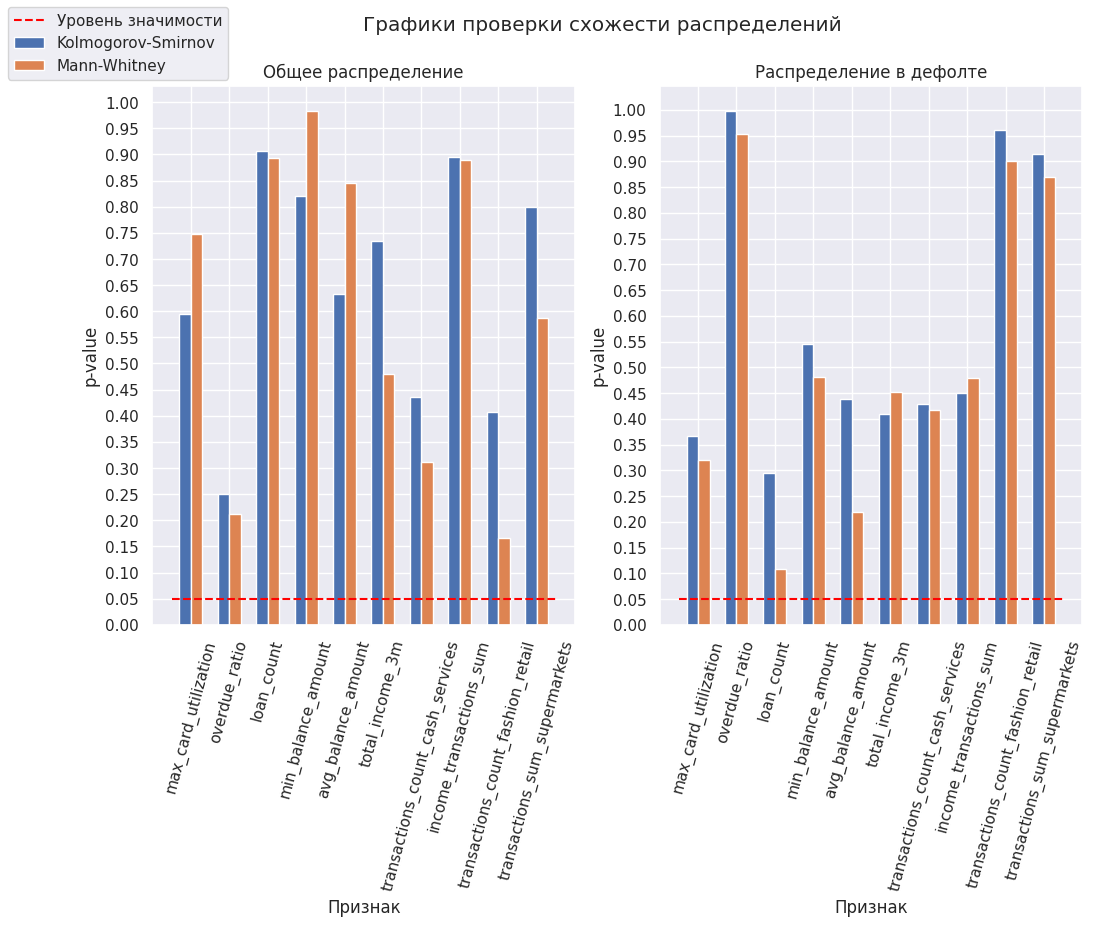

In [ ]:
plt.figure(figsize=(12, 7))

plt.suptitle('Графики проверки схожести распределений')

plt.subplot(1, 2, 1)
plt.title('Общее распределение')
x = np.arange(0, 10, 1)
w=0.3
plt.bar(x-w/2, df_tests['ks_p (all)'], width=w, align='center', label='Kolmogorov-Smirnov')
plt.bar(x+w/2, df_tests['mw_p (all)'], width=w, align='center', label='Mann-Whitney')
plt.hlines(0.05, -0.5, 9.5, linestyles='dashed', color='red',  label='Уровень значимости')
plt.xlabel('Признак')
plt.ylabel('p-value')
plt.xticks(x, df_tests.index, rotation=75)
plt.yticks(np.arange(0, 1.05, 0.05))

plt.subplot(1, 2, 2)
plt.title('Распределение в дефолте')
plt.bar(x-w/2, df_tests['ks_p (def)'], width=w, align='center')
plt.bar(x+w/2, df_tests['mw_p (def)'], width=w, align='center')
plt.hlines(0.05, -0.5, 9.5, linestyles='dashed', color='red')
plt.xlabel('Признак')
plt.ylabel('p-value')
plt.xticks(x, df_tests.index, rotation=75)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.figlegend(loc='upper left')

plt.show()

Графики явно показывают отсутсвие значимых различий в распределениях. Здесь стоит отметить лишь разную "степень уверенности" в зависимости от части выборки для каждого признака (достаточно лишь сравнить высоты соответствующих столбцов на правом и левом графиках - почти все различаются)  

## Анализ работы модели на валидационной выборке

Последним этапом валидации является анализ скоров модели на двух выборках. Сперва отрисуем гистограммы распределений

In [ ]:
y_train['score'] = model.predict_proba(X_train_selected)[:, 1]
y_test['score'] = model.predict_proba(X_test_selected)[:, 1]

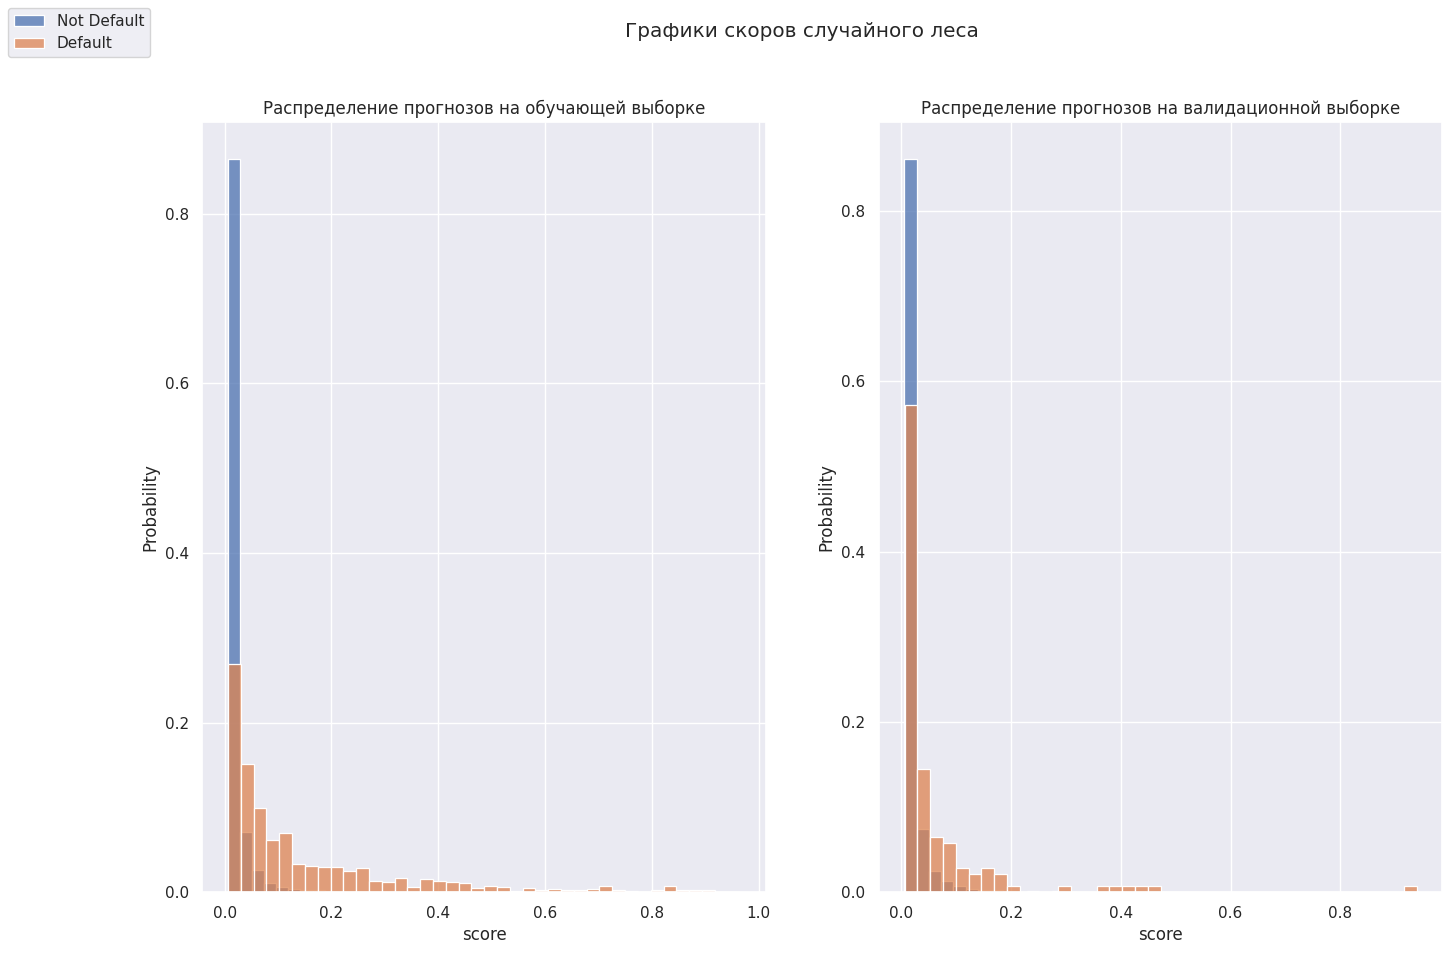

In [ ]:
plt.figure(figsize=(16, 10))
plt.suptitle('Графики скоров случайного леса')

plt.subplot(1, 2, 1)

plt.title('Распределение прогнозов на обучающей выборке')
sns.histplot(data=y_train[y_train.target == 0], x='score', stat='probability', bins=40, label='Not Default')
sns.histplot(data=y_train[y_train.target == 1], x='score', stat='probability', bins=40, label='Default')

plt.subplot(1, 2, 2)

plt.title('Распределение прогнозов на валидационной выборке')
sns.histplot(data=y_test[y_test.target == 0], x='score', stat='probability', bins=40)
sns.histplot(data=y_test[y_test.target == 1], x='score', stat='probability', bins=40)

plt.figlegend(loc='upper left')
plt.show()

Видно, что на втором графике значительно большая доля дефолтов приходится на маленький скор (область, где по идее должны находится недефолтники). При этом, самое распределение скоров дефолтников стало менее равномерным (для недефолтников все более-менее так же).

Логично предположить сильный дрейф скоров для дефолтников. Чтобы представить это более наглядно, построим графики кумулятивной функции распределения

In [ ]:
ecdf_scores_train_nodef = ECDF(y_train.loc[y_train.target == 0, 'score'])
ecdf_scores_test_nodef = ECDF(y_test.loc[y_test.target == 0, 'score'])
ecdf_scores_train_def = ECDF(y_train.loc[y_train.target == 1, 'score'])
ecdf_scores_test_def = ECDF(y_test.loc[y_test.target == 1, 'score'])

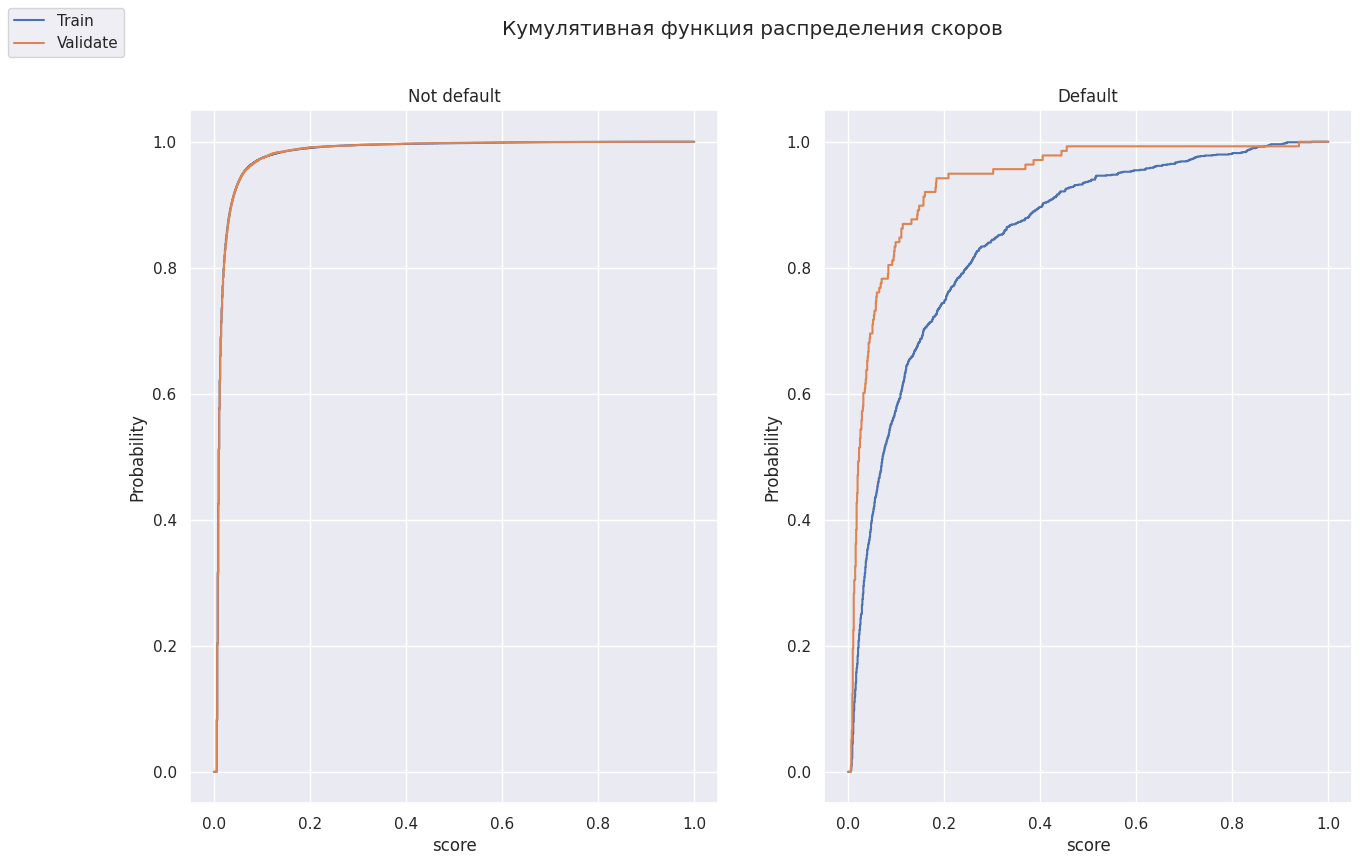

In [ ]:
x = np.linspace(0, 1, 1_000)

plt.suptitle('Кумулятивная функция распределения скоров')

plt.subplot(1, 2, 1)

plt.title('Not default')
plt.step(x=x, y=ecdf_scores_train_nodef(x), label='Train')
plt.step(x=x, y=ecdf_scores_test_nodef(x), label='Validate')
plt.xlabel('score')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)

plt.title('Default')
plt.step(x=x, y=ecdf_scores_train_def(x))
plt.step(x=x, y=ecdf_scores_test_def(x))
plt.xlabel('score')
plt.ylabel('Probability')

plt.figlegend(loc='upper left')
plt.show()

На рисунке выше еще четче прослеживаются практически совпадение распределений скоров у недефлтников и серьезные разлчиия у дефолтников. Чтобы окончательно убедится в этом, воспользуемся связкой Колмогоров-Смирнов + Манн-Уитни (уровень значимости - 5%), а так же рассчитаем своеобразный показатель "расстояния" между распределениями - PSI (критический уровень на отсутствие дрейфа - 0.1)

In [ ]:
def empiric_pdf(data, range, bins=10):
    """Функция расчета эмпирической функции распределения"""
    return np.histogram(data, bins, range=range)[0] / data.shape[0]

def KL_dist(a, b):
    """Функция расчета расстояния Кульбака-Лейблера"""
    return np.sum(a * np.where(a * b != 0, np.log(a / b), 0))

def PSI(a, b):
    """Функция расчета индекса PSI"""
    return KL_dist(a, b) + KL_dist(b, a)

def get_tests_res(score_train, score_test):
    ks_p = sps.kstest(score_train, score_test).pvalue
    mw_p = sps.mannwhitneyu(score_train, score_test).pvalue
    psi = PSI(empiric_pdf(score_train, [0, 1]), empiric_pdf(score_test, [0, 1]))

    return ks_p, mw_p, psi

In [ ]:
data = {
    'KS': [],
    'MW': [],
    'PSI': []
}

ks_p, mw_p, psi = get_tests_res(y_train['score'], y_test['score'])
data['KS'].append(ks_p)
data['MW'].append(mw_p)
data['PSI'].append(psi)

ks_p, mw_p, psi = get_tests_res(y_train.loc[y_train.target == 1, 'score'], y_test.loc[y_test.target == 1, 'score'])
data['KS'].append(ks_p)
data['MW'].append(mw_p)
data['PSI'].append(psi)

ks_p, mw_p, psi = get_tests_res(y_train.loc[y_train.target == 0, 'score'], y_test.loc[y_test.target == 0, 'score'])
data['KS'].append(ks_p)
data['MW'].append(mw_p)
data['PSI'].append(psi)

res_df = pd.DataFrame(data=data, index=['All', 'Default', 'Not Default'])

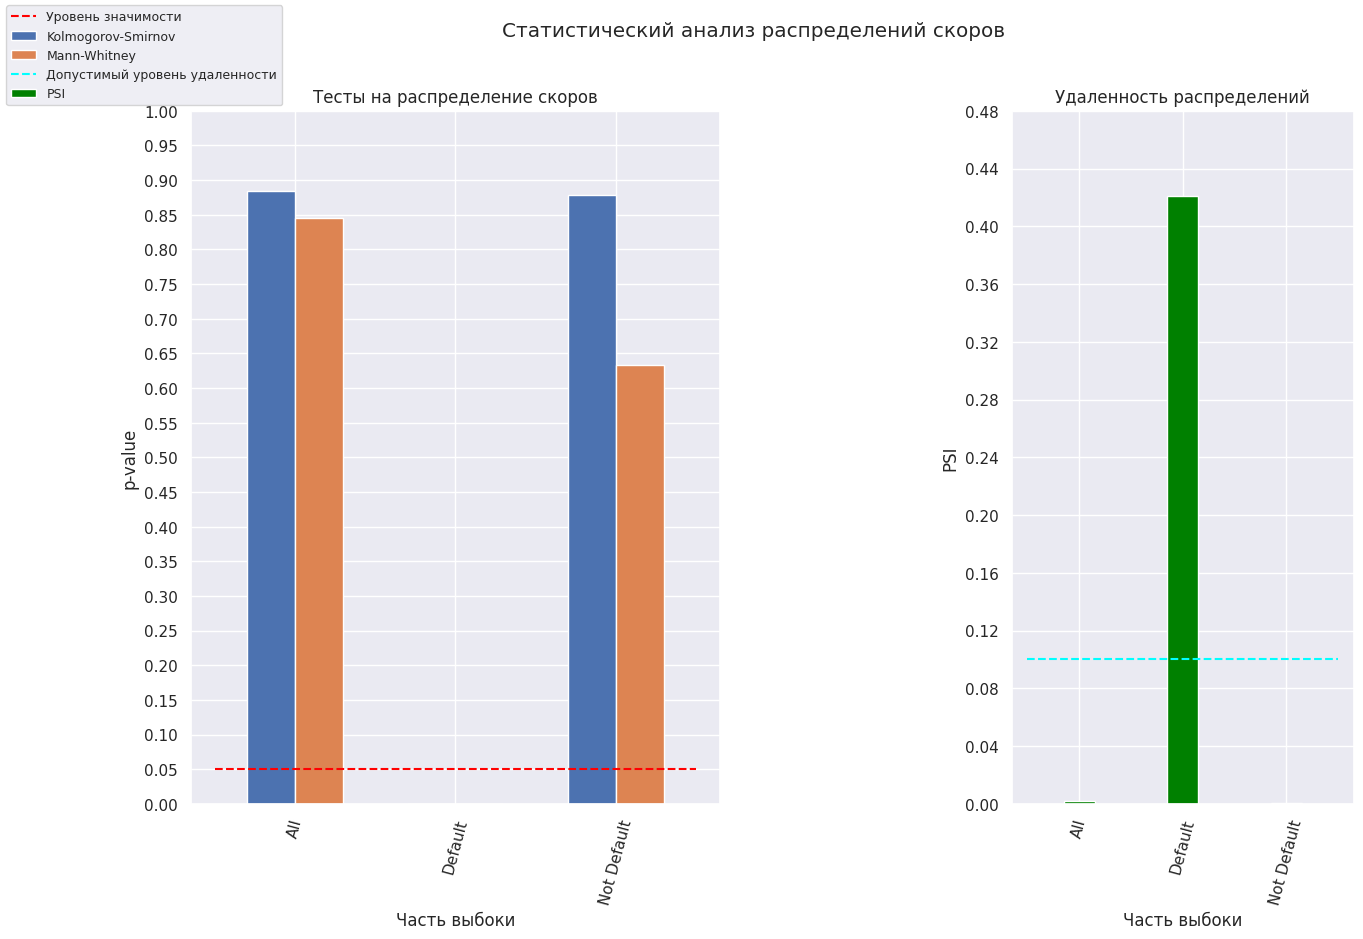

In [ ]:
plt.suptitle('Статистический анализ распределений скоров')

plt.subplot(1, 2, 1)
plt.title('Тесты на распределение скоров')
x = np.arange(0, 3, 1)
w=0.3
plt.bar(x-w/2, res_df['KS'], width=w, align='center', label='Kolmogorov-Smirnov')
plt.bar(x+w/2, res_df['MW'], width=w, align='center', label='Mann-Whitney')
plt.hlines(0.05, -0.5, 2.5, linestyles='dashed', color='red',  label='Уровень значимости')
plt.xlabel('Часть выбоки')
plt.ylabel('p-value')
plt.xticks(x, res_df.index, rotation=75)
plt.yticks(np.arange(0, 1.05, 0.05))

plt.subplot(1, 3, 3)
plt.title('Удаленность распределений')
w=0.3
plt.bar(x, res_df['PSI'], width=w, align='center', label='PSI', color='green')
plt.hlines(0.1, -0.5, 2.5, linestyles='dashed', color='cyan',  label='Допустимый уровень удаленности')
plt.xlabel('Часть выбоки')
plt.ylabel('PSI')
plt.xticks(x, res_df.index, rotation=75)
plt.yticks(np.arange(0, 0.5, 0.04))

plt.figlegend(loc='upper left', fontsize=9)
plt.show()

Графики еще раз подтверждают то, что было отмечено выше: распределение в не дефолте совпадают, а в дефолте - значимо отличаются. При этом, стоит отметить, что рассчитывая для выборки целиком, мы бы не смогли выявить этого факта; поэтому, важно рассчитывать в разрезах сегментов целевой переменной.

## Итог по валидации

Подведем некоторый итог про проведенной валидации:

1. Использованное признаковое пространство в целом является адекватным методологии отбора признаков (см раздел про построение моделей). Единственное, имеется ряд признаков с близким к пороговому значениями пропусков (max_card_utilization и transactions_sum_supermarkets) - необходимо более аккуратно мониторить уровень пропусков в них.
2. Построенная модель является адекватной, ложных логических корреляций не порождается. В самой структуре модели наблюдается некоторый дисбаланс в значимости, из-за чего повышается чувствительность к дрейфам отдельных признаков.
3. В валидационной выборке серьезных отличий в распределении признаков не обнаружено; имеется некоторое стат. значимое различие в квантилях, однако оно не критично.
4. Скоры модели на валидационной и обучающей выборках значительно различаются в сегменте дефолтников; основное различие в части с малыми скорами. Вероятно следовало бы дополнить текущую архитектуру несложной моделью, которая могла бы особенно корректировать часть наблюдений с малыми скорами (повысить разделяющую способность в этой зоне). Тем не менее, общее значение ROC-AUC (порядка 0.75 - приводить код не стал (итак слишком много)) находится на уровне отраслевого стандарта, так что на короткой дистанции применение этой модели может быть оправдано (за неимением лучшего естественно)